# Moscow housing prediction [Long]

Written by<br> 

Hauk Aleksander Olaussen - **Student ID: *504903*** <br>

Charbel Badr - **Student ID: *557389***<br>

Noran Baskaran - **Student ID: *504877*** <br>

Kaggle competition name: **Moscow housing**

Kaggle team name: **Team 69**


## Introduction

For this project we were tasked to create a machine learning algorithm that could predict house prices in Moscow based on a set of housing features and known prices for the given house or apartment.
This notebook will give insight into how we explored the data to find out if any of the data was related to each other, and vice versa. It will show how we altered and formed the given dataset into something our machine learning model would understand better by removing features that does not have as much influence on the price, and adding features that did. This way, we managed to improve the score of the algorithm by engineering the data to our advantage.

Through the notebook, we will give examples in text, code and images (graphs) to give a complete discussion, allowing you to follow our thought process all the way from initial thoughts to finished model.

We will initially seperate the notebook into sections, making it easy to follow:
* **Data exploration and cleaning**
* **Feature engineering**
* **Trying different models**
* **Tuning hyperparameters**
* **Analyzing the error**

These will intertwine in later sections, as molding the data is a complicated process.


The following code will allow us to auto reload code when changes are made.

In [198]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We begin with importing external and self made modules. Below you can see a description of the modules used:

- `numpy` is the defacto python package for numerical calculation. Most other numerical libraries (including pandas) is based on numpy
- `pandas` is a widely used package for manipulating (mostly) tabular data
- `matplotlib` is the most used plotting library for python
- `seaborn` contains several convience functions for matplotlib and integrates very well with pandas
- `train_test_split` used for splitting training data into actual training and validation data
- `Visualizer` contains several functions used to plot different parts of the data and their correlation
- `Preprocessor` contains the main bulk of code used to preprocess and feature engineer the data provided to transform the data into something more understandable to a model
- `TestModel` contiains the code used for model prediction and analysis


In [199]:
%autoreload
 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from Visualizer import Visualizer
from Preprocessor import Preprocessor
from TestModel import TestModel
import xgboost

sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

## Data exploration and cleaning

In this section we want to get a good look at the data. We want to find out what datatypes we must work with, how the structure looks like, and if we have any *NaN* values we need to work around.
The dataset is split into two different files - namely **buildings** and **apartments**. Apartments have a field which points to a building, connecting the two. This is something we will have to look at later in the process, as a building has a lot to say about the standards of the apartment. 

Below you can see the head entries for both the *apartments* and *buildings*.

### Apartments

#### Training data

In [200]:
preprocessor = Preprocessor()
apartments = preprocessor.apartments
apartments.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604


#### Test data

In [201]:
apartments_test = preprocessor.apartments_test
apartments_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,'5148'
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530


### Buildings

#### Training data

In [202]:
buildings = preprocessor.buildings
buildings.head()

,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,264,0.0,55.518117,37.355139,11.0,улица 1-я Нововатутинская,3,2019.0,2.0,12.0,1.0,1.0,1.0,0.0,1.0,3.0
1,6079,0.0,55.641920,37.352156,7.0,мкр. 10-й,к1014,1981.0,3.0,22.0,0.0,1.0,1.0,NaN,1.0,0.0
2,5829,0.0,55.770011,37.386220,7.0,Рублевское шоссе,68,2002.0,3.0,24.0,0.0,1.0,1.0,NaN,NaN,0.0
3,5758,0.0,55.739934,37.426070,7.0,Рублевское шоссе,93К2,2011.0,3.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0
4,6761,0.0,55.649921,37.467994,7.0,улица Академика Анохина,58К2,2005.0,3.0,22.0,0.0,1.0,1.0,NaN,0.0,0.0


#### Test data

In [203]:
buildings_test = preprocessor.buildings_test
buildings_test.head()

,id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,6659,0.0,55.802771,37.510709,1.0,улица Алабяна,3К3,1962.0,0.0,8.0,0.0,1.0,0.0,NaN,1.0,0.0
1,369,1.0,55.511730,37.351958,11.0,Кленовые Аллеи ЖК,к2,2020.0,NaN,15.0,0.0,1.0,1.0,1.0,NaN,NaN
2,5658,0.0,55.865763,37.541790,1.0,Коровинское шоссе,3К1,1967.0,3.0,9.0,0.0,1.0,0.0,NaN,1.0,0.0
3,5903,0.0,55.848640,37.516745,1.0,3-й Лихачевский переулок,5,1985.0,3.0,14.0,0.0,1.0,1.0,NaN,1.0,0.0
4,7782,1.0,55.499290,37.521309,11.0,Остафьево ЖК,к6,2020.0,2.0,13.0,1.0,1.0,1.0,1.0,0.0,NaN


**Great!**
This gives us some initial insight on how the data looks. We see that we have a lot of different features here. Some of them will probably not influence the price at all (or at least to a very low degree), and some may influence the price a great deal. The data has a combination of numerical, ordinal and categorical features, which is good. This variety opens a lot of doors for us when we are to explore and engineer the data later.

We can also see that we have a lot of *NaN* values in the data - which is something we will have to deal with.

First, let us combine the **apartments** and **buildings** based in the *bulding_id* field to get a better look.

### Merging apartments and buldings

#### Training data

In [204]:
merged = preprocessor.merged.copy()
merged.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076,1.0,55.544046,37.478055,11.0,Бунинские Луга ЖК,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176,1.0,55.663299,37.515335,6.0,Саларьево Парк ЖК,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,улица Сервантеса,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


#### Test data

In [205]:
merged_test = preprocessor.merged_test.copy()
merged_test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,5148,0.0,55.762247,37.549040,0.0,2-я Черногрязская улица,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290,0.0,55.591467,37.452651,11.0,улица Сервантеса,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681,1.0,55.617017,37.413718,11.0,Саларьево Парк ЖК,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261,0.0,55.569052,37.479510,11.0,улица Александры Монаховой,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530,0.0,55.518041,37.343829,11.0,улица 3-я Нововатутинская,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


### Merging the training and test sets into one
We will now merge these dataframes into one. We do this so we can be sure that the preprocessing is uniform across both the training, and test set. One important thing to remember is that the test set does not have a *price* feature, as this is the whole task. Because of this, we will need to remember where the training data stops, and the test data starts. This happens as index ***23284***


In [206]:
merged_final = pd.concat([merged, merged_test], ignore_index=True)
print(f"The dataframe now has {len(merged_final)} entries")

The dataframe now has 33222 entries


### Finding the NaNs
Lets see how many *NaN* values we are dealing with for each feature in the newly created combined dataframe.

In [207]:
visualizer = Visualizer()
visualizer.list_missing(merged_final.copy())

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 12772 | 38.44%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 6954 | 20.93%
area_living: Amount: 5901 | 17.76%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
layout: Amount: 25010 | 75.28%
ceiling: Amount: 16111 | 48.49%
bathrooms_shared: Amount: 5589 | 16.82%
bathrooms_private: Amount: 5589 | 16.82%
windows_court: Amount: 11560 | 34.8%
windows_street: Amount: 11560 | 34.8%
balconies: Amount: 15355 | 46.22%
loggias: Amount: 15355 | 46.22%
condition: Amount: 13769 | 41.45%
phones: Amount: 120 | 0.36%
building_id: Amount: 0 | 0.0%
new: Amount: 373 | 1.12%
latitude: Amount: 2 | 0.01%
longitude: Amount: 2 | 0.01%
district: Amount: 155 | 0.47%
street: Amount: 0 | 0.0%
address: Amount: 0 | 0.0%
constructed: Amount: 1168 | 3.52%
material: Amount: 5643 | 16.99%
stories: Amount: 0 | 0.0%
elevator_without: Amount: 537 | 1.62%
elevator_passenger: Amount: 537 | 1.62%
elevator_service: Amount: 537 | 1.62%
par

We see that the majority of the features has some *NaN* values. Some of them, like *layout* has a lot - **25k** out of **33**. <br>
Multiple fields have over 40% *NaNs*.

Also, notice that price has 9937 *NaN* values, as we have combined the dataframes.

### Initial removing and filling of features
We will remove features we do not believe we will need (those with an overwhelming amount of *NaNs*) and features consisting of strings (such as the street and address), which will be impossible to categorize. We will also remove the *elevator_without* feature, as the two other elevator feature will tell us what this boolean value should be. All this is done by the `Preprocessor.general_removal()` function. The removal of these values is something which might be redone later, as we find better way of utilizing them.

We will also do a general clean-up of the *NaN* values. We do this with the `Preprocessor.remove_NaNs()` function. It will fill in data for all *NaN* values. For continuous values we do this by calculating some sort of average or mean for each district in a combined set of both training and test data. For categorical values, this is mostly done by using the most used value - or *mode*. For some values we try imputing the *NaNs* with the same as other apartments in the same building.

In [208]:
general_removed = preprocessor.general_removal(merged_final.copy())
data = preprocessor.remove_NaNs(general_removed.copy())
data = preprocessor.impute_nans_with_building_id(data.copy(), ["condition"]) # Fills in NaNs for categorical data with the same value as another apartment in the same building (if it exists)
visualizer.list_missing(data)

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 0 | 0.0%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 0 | 0.0%
area_living: Amount: 0 | 0.0%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
bathrooms_shared: Amount: 0 | 0.0%
bathrooms_private: Amount: 0 | 0.0%
windows_court: Amount: 0 | 0.0%
windows_street: Amount: 0 | 0.0%
condition: Amount: 0 | 0.0%
phones: Amount: 0 | 0.0%
building_id: Amount: 0 | 0.0%
new: Amount: 0 | 0.0%
latitude: Amount: 0 | 0.0%
longitude: Amount: 0 | 0.0%
district: Amount: 0 | 0.0%
constructed: Amount: 0 | 0.0%
material: Amount: 0 | 0.0%
stories: Amount: 0 | 0.0%
elevator_passenger: Amount: 0 | 0.0%
elevator_service: Amount: 0 | 0.0%
parking: Amount: 0 | 0.0%
garbage_chute: Amount: 0 | 0.0%
heating: Amount: 0 | 0.0%


This proves we have removed all the *NaN* values in the dataset except price, which makes sense.<br>
Lets convert the categorical data - which is now represented as floats - to actual categorical data.
The head now looks the same as it would, but the datatypes are now categorical.

In [209]:
data = preprocessor.fix_categorical(data.copy())
data.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,0.0,2.0,0.0,1.0,-1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,-1.0,-1.0
1,1,-1.0,10500000.0,88.0,14.2,48.0,18.0,3.0,2.0,0.0,1.0,1.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,0.0,2.0,1.0,1.0,-1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,-1.0,-1.0
3,3,-1.0,10500000.0,88.0,14.0,48.0,18.0,3.0,0.0,2.0,1.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
4,4,-1.0,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,0.0,1.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0


### Visualizing the distribution of features
Below, you can see graphs for all the features in the merged dataframe. It gives some insight into how the data is distributed across the dataset.

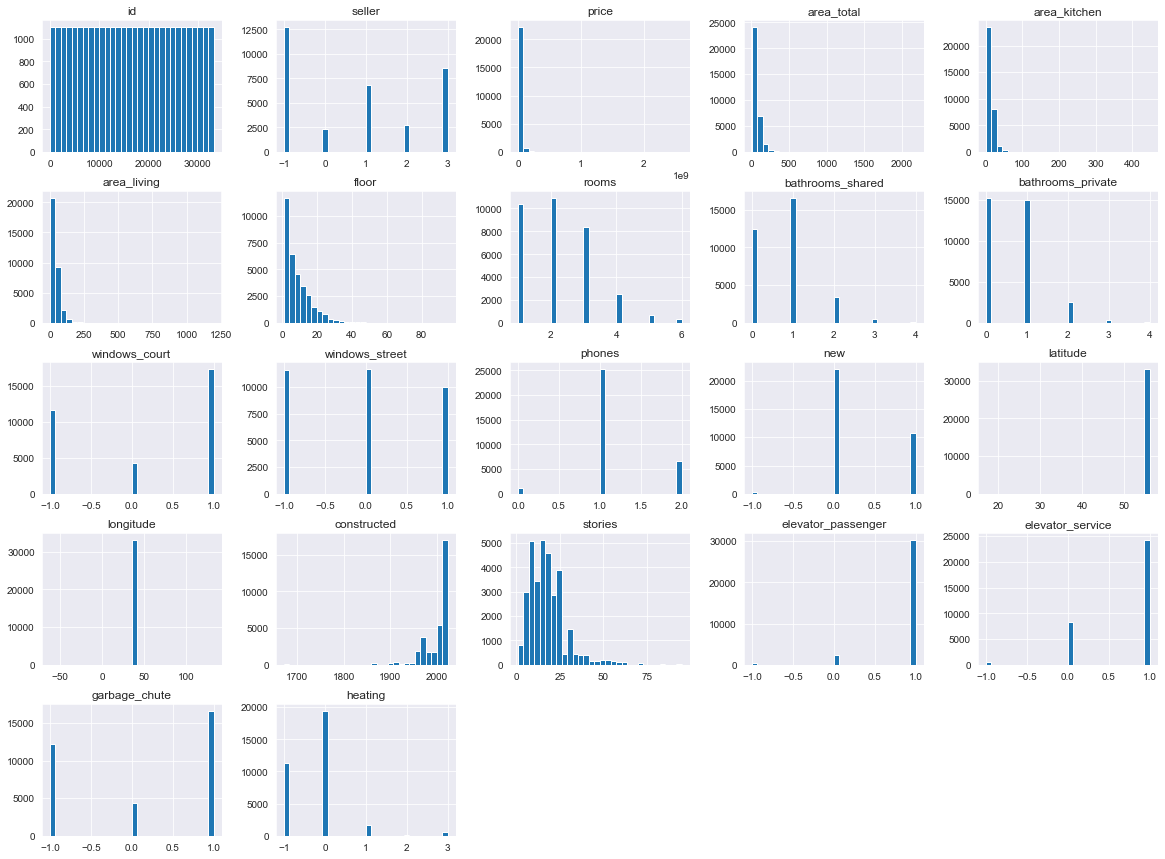

In [210]:
data.hist(bins=30, figsize=(20,15))
plt.show()

What we are looking for here are data with odd distributions. We can see that some of these diagrams are heavily "one sided". What we mean by this is that some of the data has mostly one value, or is skewed in some way. We can remove this by taking the logarithm of the given variables. We start doing this in the feature engineering part

### Visualizing correlations

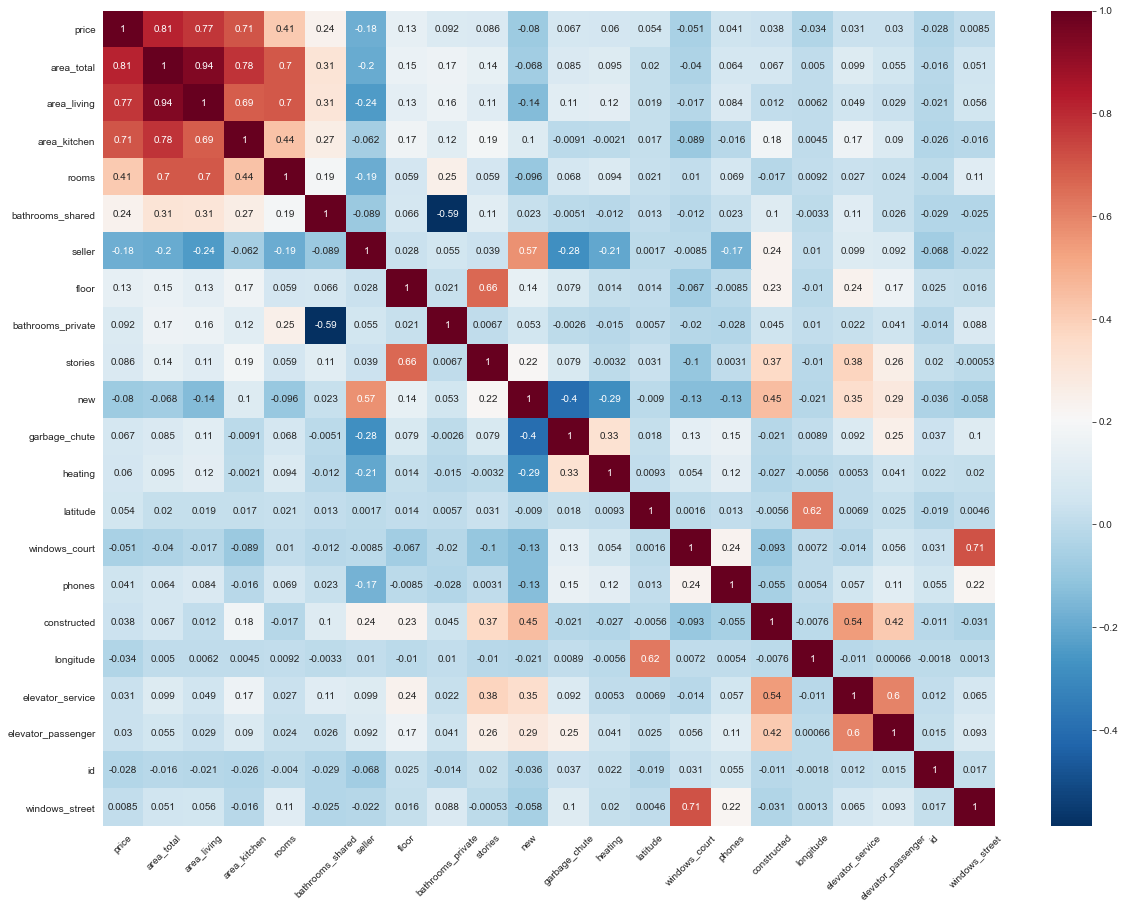

In [211]:
visualizer.price_correlation(data)

**Whoa!**<br>
That was quite a grid.
We can however remove some more features just by looking at this grid. There are some features with next to none correlation with the price, and some with a very high correlation.

Below is a summary of the correlations we can see between the data that have made it through the cleaning so far.. <br>
Some takeouts:
- Total area, living area, kitchen area and price are very correlated
- Amount of rooms and price are highly correlated
- Parking and price are somewhat correlated
- Amount of stories in the building and apartment floor are highly correlated
- Bathrooms private and bathrooms shared are very negatively correlated
- New and seller are somewhat correlated
- Windows street and windows court are very negatively correlated
- District and latitude/longitude are very correlated
- Constructed and the elevator features are highly correlated

## More exploration and some feature altering

Lets continue the exploration by plotting some of the distrubutions of the features with the highest correlation to price.<br>
We start with the price itself.

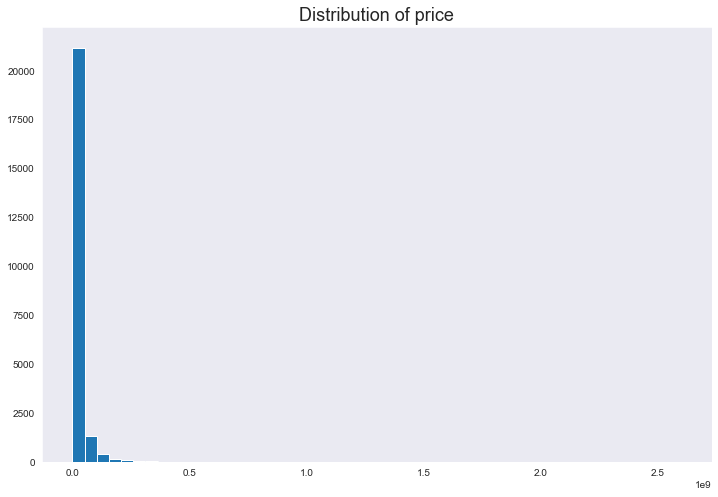

In [212]:
visualizer.plot_distribution(data, "price")

As we mentioned earlier, we can see that this value is heavily skewed. By taking the logarithm of the price, we get a much more spread out target for the algorithm. This will help it pinpointing more accurately where it want the price prediction to be. All we have to to is to convert it back to an actual price value. You can see the logified plot below.

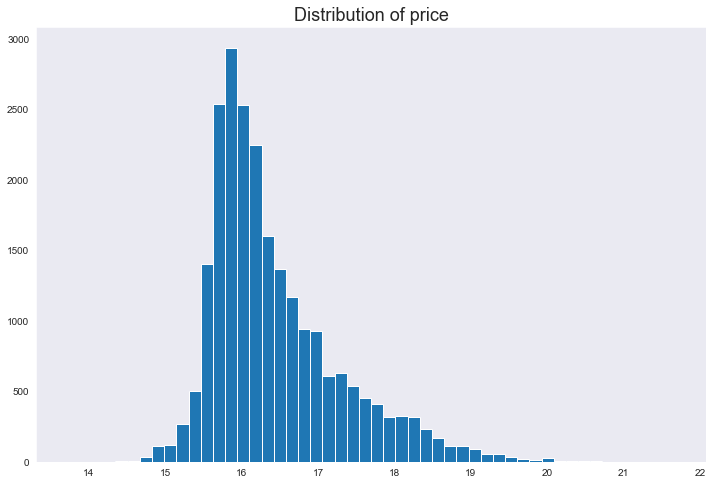

In [213]:
data = preprocessor.logify(data.copy(), "price")
visualizer.plot_distribution(data, "price")

Now we look at the total area. 

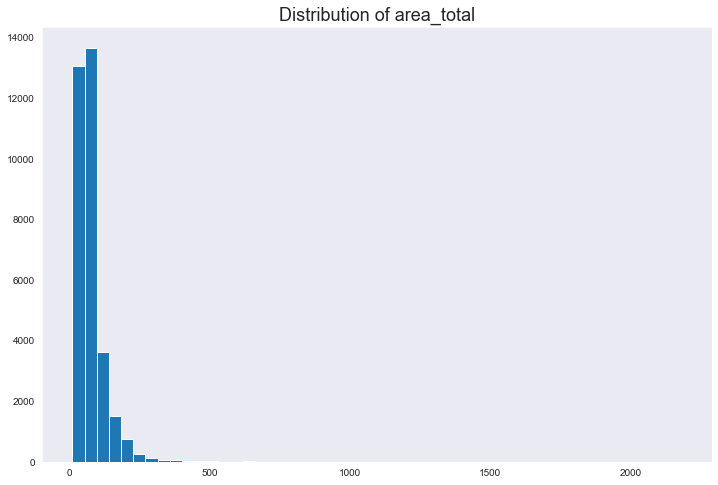

In [214]:
visualizer.plot_distribution(data, "area_total")

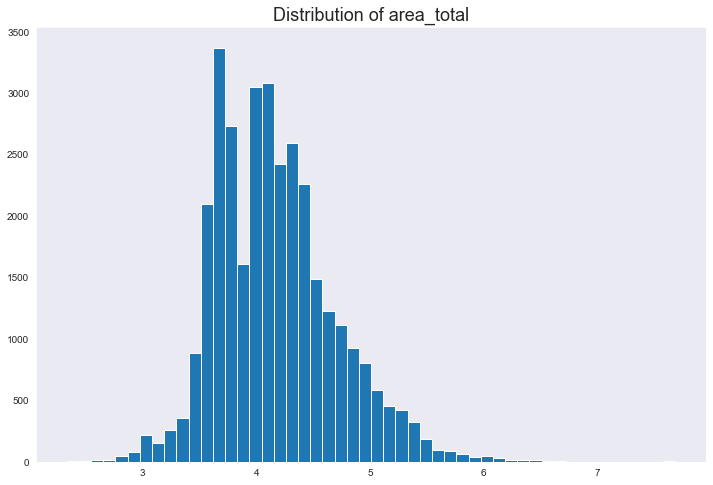

In [215]:
data = preprocessor.logify(data.copy(), "area_total")
visualizer.plot_distribution(data, "area_total")

When taking the logarithm of the total area we get this distribution. This is the feature with the highest correlation to price - which of course is not surprising. It is, however, also highly correlated so some other features, namely living area, kitchen area and the amount of rooms. One way of dealing with this could be to create a new feature with these combined in some way, or by splitting them even further. We will look into this in the feature engineering part of the notebook.

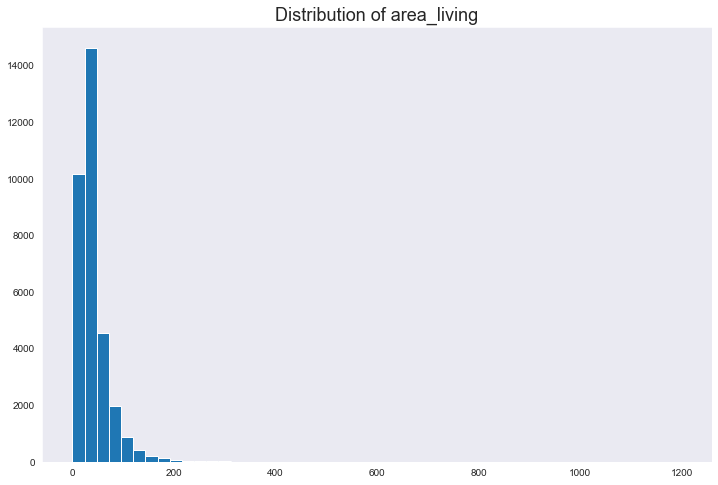

In [216]:
visualizer.plot_distribution(data, "area_living")

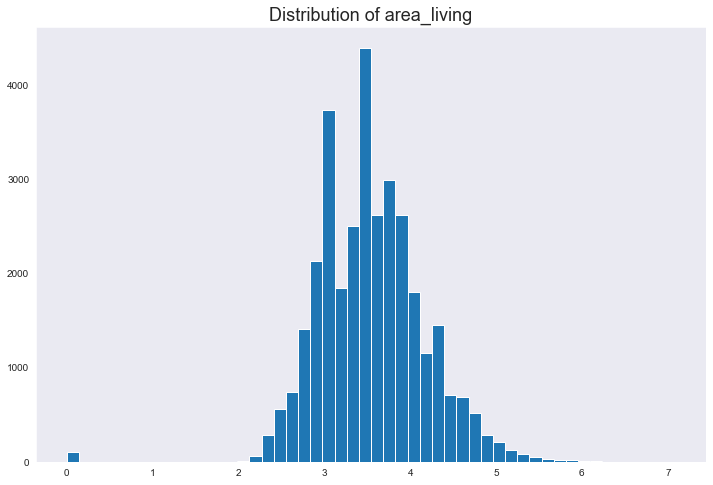

In [217]:
data = preprocessor.logify(data.copy(), "area_living")
visualizer.plot_distribution(data, "area_living")

This shows something worth fixing. The living area will never be 0. This is just as worthless as it being *NaN*. Because of this, we fix it so that the 0 values use the average from their district. The new distribution looks like this:

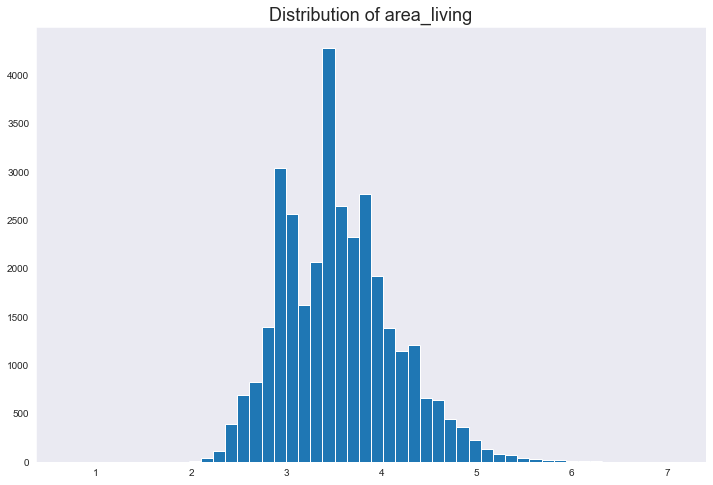

In [218]:
data = preprocessor.remove_zero_values(data.copy(), "area_living")
visualizer.plot_distribution(data, "area_living")

Because this phenomenon was present in the *area_living* feature, we check the *area_kitchen* feature as well.

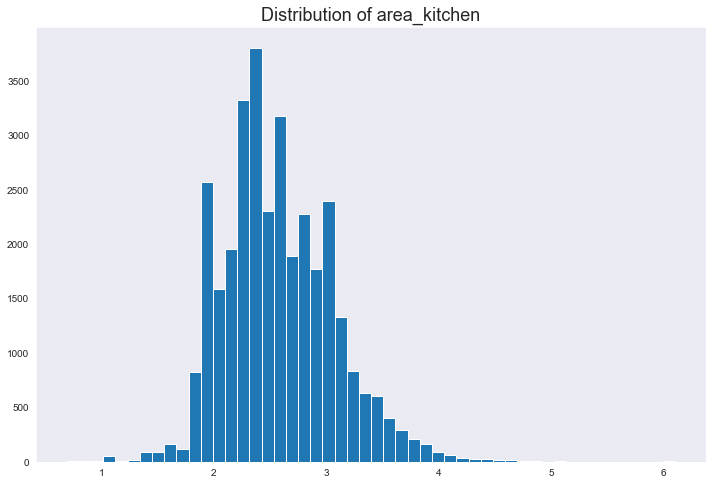

In [219]:
data = preprocessor.logify(data.copy(), "area_kitchen")
visualizer.plot_distribution(data, "area_kitchen")

Luckily, this problem was not present in this column. Still, as the feature was very skewed (as previuosly mentioned), we keep it logified.

## Scattering some correlations

The correlation grid above gives us good insight in how the features are correlated to each other, but is of course not everything we need. In this section we will plot different features  each other to visualize the correlations between them. This may lead to us finding features we want to combine, but may also lead to us finding that we do not need a spesific feature. We will see.

Visualizing the correlations between different features will give us futher insight in how we will transform and change the data in later sections. For plotting with the price, we will use just the training data part of the dataframe, as the test part does not have this feature

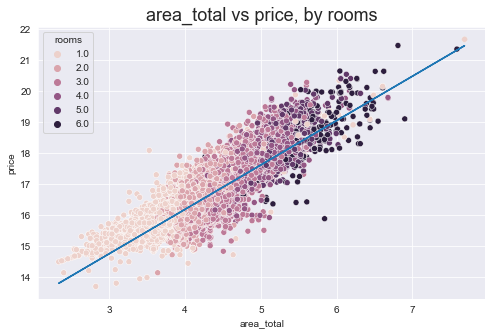

In [220]:
data_with_price = data[:23285].copy()
visualizer.plot_vs(data_with_price, "area_total", "price", reg=True, figsize=(8,5), hue="rooms")

Using rooms as the hue here shows that the more expensive apartments, which are often the largest, also have the most rooms. This shows a clear correlation between total area and the amount of rooms, which we already knew. However, the separation here are quite clear, making it even more obvious that these two depend on each other.

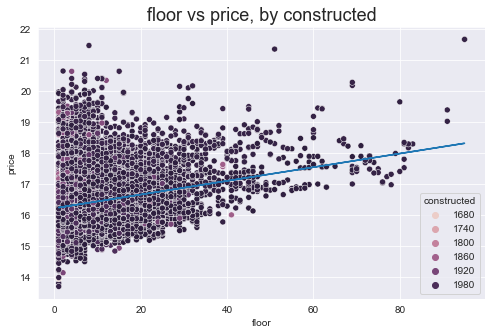

In [221]:
visualizer.plot_vs(data_with_price, "floor", "price", reg=True, figsize=(8,5), hue="constructed")

This shows something interesting. For one it shows that often, the higher the floor, the higher the price. But it also shows that the vast majority of the apartments are built in the 2010s, and they are everywhere on the plot. Meaning that the year of construction might not have as much to say when it comes to price than one might think. Lets plot this.

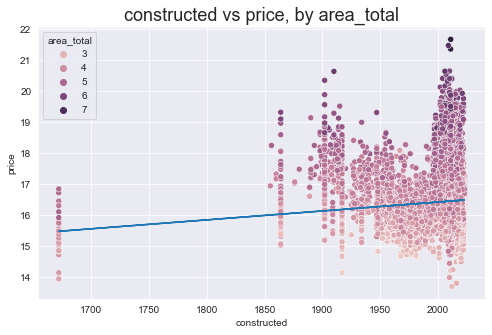

In [222]:
visualizer.plot_vs(data_with_price, "constructed", "price", reg=True, figsize=(8,5), hue="area_total")

Look at that. The price based on construction year is very scattered around. It look like the construction year does not really matter as much as one might think when it comes to price. You can clearly see "average" vertial lines where we have imputed the valies, but still - it shows that it does not have that much to say for the price of the apartment. We have set the hue to show the total area in this case, showing that even though some of the old buildings are large, they are not that much bigger than apartments in the same price range built many years later. This is fascinating. 

We did not plot all features here, but just a select few, just to show that some of these features are very scattered. This means that even though some correlation does exist, it will be quite hard to know where to place the price for a new apartment based on the training data. 

Before starting the feature engineering, lets plot some of the features against each other, and not only the price. This will give us some insight in how the features are correlated to each other, and not only the price. Maybe we can find a way to create new and better features out of this exploration? Lets see.

#### Exploring features correlated to eachother

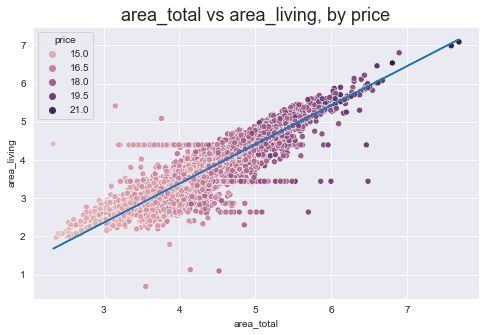

In [223]:
visualizer.plot_vs(data, "area_total", "area_living", reg=True, figsize=(8,5), hue="price")

As we thought, total area, living area and rooms are very correlated. The price of the apartment also follows this trend it seems. We will look at this correlation when we start feature engineering as these might be eligible for altering and/or combining.

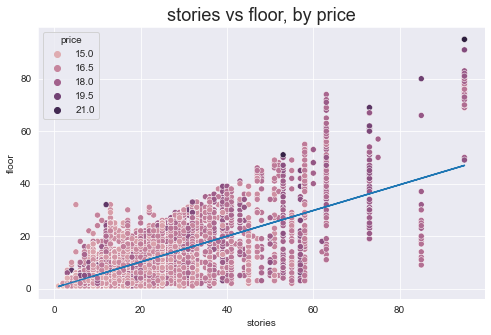

In [224]:
visualizer.plot_vs(data, "stories", "floor", reg=True, figsize=(8,5), hue="price")

This plot shows a clear correlation with stories and floor. Of course, it is not very surprising that apartments on higher floors are in buildings with more stories. The hue here is based on the price, showing some lean towards higher story buldings, and apartments on the higher floors of them. Maybe something to think about 

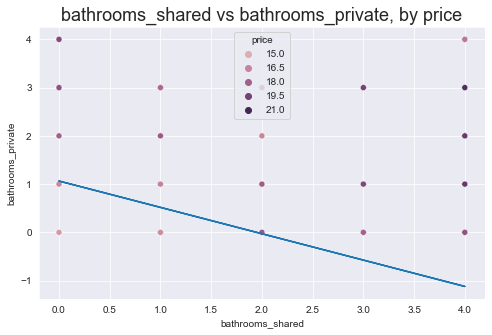

In [225]:
visualizer.plot_vs(data, "bathrooms_shared", "bathrooms_private", reg=True, figsize=(8,5), hue="price")

Nothing very surprising here. When the amount of private bathrooms goes down, the amount of shared bathrooms go up, and vice versa.

Lets look at the latitude and longitude. These are features we will combine later to find the distance to different things around town. They should be pretty similar, as we are located inside the same city.

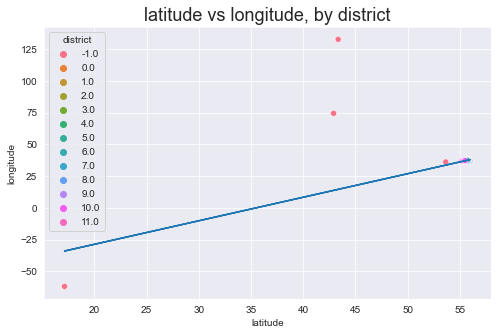

In [226]:
visualizer.plot_vs(data, "latitude", "longitude", reg=True, figsize=(8,5), hue="district")

Now this is weird. We can see almost all the apartments are clumped together around *latitude* = 55 and *longitude* = 35 (roughly), but there are some apartments not even close to the rest. Lets try finding these apartments, and how many they are:

In [227]:
is_outlier = (data["longitude"] > 55) | (data["latitude"] < 54)
outliers = data.copy()[is_outlier]
outliers

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
23308,23308,-1.0,NaN,3.688879,2.484907,2.772589,6.0,1.0,1.0,0.0,1.0,0.0,-1.0,1.0,3803,1.0,53.651999,36.264789,-1.0,2019.0,2.0,12.0,1.0,1.0,-1.0,-1.0,-1.0
23375,23375,1.0,NaN,3.754199,2.468100,3.010621,13.0,1.0,1.0,0.0,0.0,1.0,-1.0,2.0,3803,1.0,53.651999,36.264789,-1.0,2019.0,2.0,12.0,1.0,1.0,-1.0,-1.0,-1.0
25796,25796,-1.0,NaN,3.034953,1.808289,2.341806,11.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,1.0,4636,1.0,17.141734,-61.790500,-1.0,2021.0,3.0,17.0,0.0,0.0,-1.0,0.0,-1.0
25814,25814,2.0,NaN,3.443618,1.975430,2.870662,1.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,4202,-1.0,42.914700,74.517184,-1.0,2016.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0
28004,28004,2.0,NaN,5.123964,2.944439,4.836282,5.0,4.0,1.0,2.0,1.0,1.0,2.0,1.0,8811,0.0,43.353545,132.768097,-1.0,2007.0,-1.0,5.0,1.0,1.0,1.0,1.0,-1.0
28375,28375,0.0,NaN,3.797734,1.791759,3.394508,4.0,2.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,4412,1.0,17.141734,-61.790500,-1.0,2021.0,-1.0,9.0,1.0,1.0,-1.0,-1.0,-1.0
30244,30244,-1.0,NaN,3.034953,1.808289,2.341806,11.0,1.0,0.0,1.0,-1.0,-1.0,-1.0,1.0,4636,1.0,17.141734,-61.790500,-1.0,2021.0,3.0,17.0,0.0,0.0,-1.0,0.0,-1.0
31881,31881,0.0,NaN,3.339322,1.883183,2.769168,17.0,1.0,1.0,0.0,0.0,1.0,-1.0,1.0,4412,1.0,17.141734,-61.790500,-1.0,2021.0,-1.0,9.0,1.0,1.0,-1.0,-1.0,-1.0
32832,32832,-1.0,NaN,5.247024,3.682204,4.652514,1.0,5.0,0.0,1.0,-1.0,-1.0,-1.0,1.0,5667,-1.0,43.352968,132.759204,-1.0,1994.0,-1.0,2.0,-1.0,-1.0,-1.0,-1.0,-1.0


This shows 8 outliers in the dataset. As all of them have *NaN* price, we know that these are from the testset. We can verify this by looking at the *id* field, which tells us that all of the outliers have ids larger than ***23284***. As these are not in the training set, we cannot remove them - because we need to predict prices for them. We will assume that this building is misrepresented in the test data, and will give these apartments the average latitude and longitude in a random district. We do this with the function `Preprocessor.fix_latlon_outliers()`.

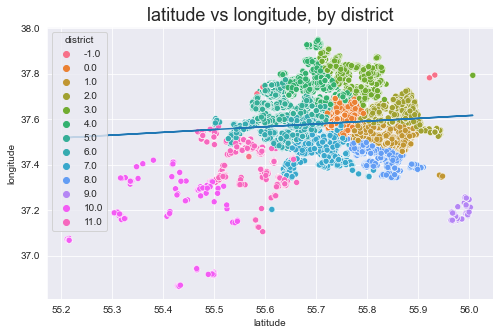

In [228]:
removed_outliers = preprocessor.fix_latlon_outliers(data.copy(), outliers)
visualizer.plot_vs(removed_outliers, "latitude", "longitude", reg=True, figsize=(8,5), hue="district")

**This is better!**
We can clearly see the different districts when we plot the latitude and longitude like this. We see that the apartments gather around a circular center, with the lower numbered districts being closer to center. We can look at this as a city center, which will probably be very important later. This is a fascinating plot, as two features not really correlating that much to the price, will have a big impact when combined later into one feature called *distance_center* - which will be the distance to the city center. 

## Feature engineering

This section is where we will change the data in a more drastic way than we have. We have already cleaned the data, removing NaNs and non-important features, but that does not mean that we will not find a way to combine other non-correlating features into new ones with actual impact. We will try to create features where they correlate to the price in a more impactful manner than they did alone, making it easier for the machine learning algorithm to predict accurately.

We will reference to earlier sections when discussing and explaining our thought processes as the insight obtained in the data exploration phase will be used all through this section. 

Earlier in this notebook we did some minor feature engineering when we removed the skew for some features using the logarithm.

In the exploration we found correlations between the total area, living area, kitchen area and the amount of rooms in an apartment. Let's see what one or more combinations of these would look like. <br>
We will create a new features for this: **avg_room_size**, **living_fraction** and **kitchen_fraction**

- **avg_room_size**: the average size of a room in the apartment.
- **living_fraction**: *area_living* / *area_total*
- **kitchen_fraction**: *area_kitchen* / *area_total*

This is done by the function `Preprocessor.combine_area_rooms()`

                  avg_room_size  living_fraction  kitchen_fraction     price
avg_room_size          1.000000        -0.438670          0.197980 -0.435678
living_fraction       -0.438670         1.000000         -0.408683  0.299087
kitchen_fraction       0.197980        -0.408683          1.000000  0.124355
price                 -0.435678         0.299087          0.124355  1.000000


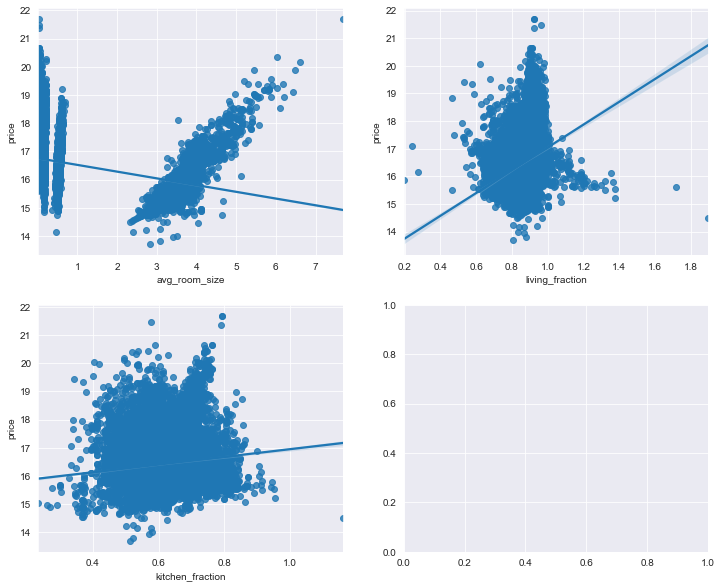

In [229]:
featured = preprocessor.combine_area_rooms(removed_outliers.copy())
visualizer.corr_target(featured, cols=["avg_room_size", "living_fraction", "kitchen_fraction"], target='price')

We see that the average room size does correlate to the price pretty well, but negatively. This means that the larger the rooms are on average, the lower the price of the apartment is. This is different from the *living_fraction* and *kitchen_fraction* where it is less correlated to the price, but positively. This means that if the living area and kitchen area is larger, the price of the apartment will most likely be higher. We will now remove the features these are based on - *area_living*, *area_kitchen* and *rooms*.

In [230]:
featured = preprocessor.remove_labels(featured.copy(), ["area_living", "area_kitchen", "rooms"])
featured

,id,seller,price,area_total,floor,bathrooms_shared,bathrooms_private,windows_court,windows_street,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,avg_room_size,living_fraction,kitchen_fraction
0,0,3.0,15.781156,4.097672,2.0,0.0,2.0,0.0,1.0,-1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,-1.0,-1.0,0.512209,0.845782,0.635163
1,1,-1.0,16.166886,4.488636,18.0,2.0,0.0,1.0,1.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0,0.166246,0.867038,0.606263
2,2,3.0,16.014916,4.375757,12.0,0.0,2.0,1.0,1.0,-1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,-1.0,-1.0,0.162065,0.853086,0.721475
3,3,-1.0,16.166886,4.488636,18.0,0.0,2.0,1.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0,0.166246,0.867038,0.603312
4,4,-1.0,16.447399,4.369448,7.0,1.0,0.0,1.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0,0.546181,0.820131,0.661496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33217,33217,3.0,NaN,4.672829,16.0,1.0,0.0,-1.0,-1.0,0.0,1.0,4252,1.0,55.789750,37.456468,8.0,2020.0,2.0,20.0,1.0,1.0,0.0,-1.0,0.0,0.173068,0.867838,0.650516
33218,33218,-1.0,NaN,4.418841,3.0,2.0,0.0,1.0,0.0,1.0,2.0,7380,1.0,55.751639,37.516260,7.0,2021.0,2.0,20.0,1.0,1.0,1.0,-1.0,-1.0,0.163661,0.866710,0.651639
33219,33219,-1.0,NaN,3.918005,15.0,1.0,0.0,-1.0,-1.0,0.0,1.0,1480,1.0,55.770659,37.375234,7.0,2016.0,2.0,24.0,1.0,1.0,0.0,1.0,1.0,3.918005,0.851290,0.614412
33220,33220,-1.0,NaN,3.683867,14.0,1.0,0.0,0.0,1.0,0.0,2.0,2154,0.0,55.699943,37.637183,5.0,2019.0,-1.0,14.0,1.0,1.0,0.0,1.0,-1.0,3.683867,0.754321,0.662985


We will also combine the bathroom features to one **bathroom_amount**, giving a more clearcut way of describing the bathroom situation

                   bathrooms_private  bathrooms_shared  bathroom_amount  \
bathrooms_private           1.000000         -0.586889         0.390924   
bathrooms_shared           -0.586889          1.000000         0.515807   
bathroom_amount             0.390924          0.515807         1.000000   
price                       0.134314          0.363446         0.553534   

                      price  
bathrooms_private  0.134314  
bathrooms_shared   0.363446  
bathroom_amount    0.553534  
price              1.000000  


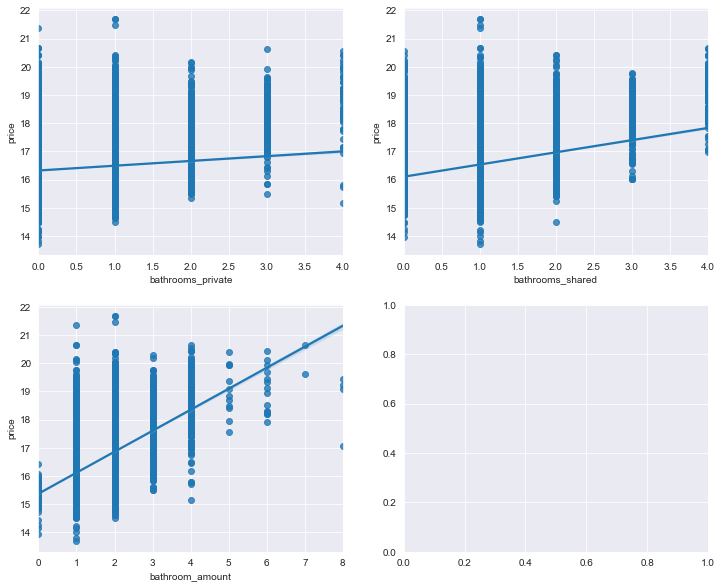

In [231]:
featured = preprocessor.combine_baths(featured.copy())
visualizer.corr_target(featured, cols=["bathrooms_private", "bathrooms_shared", "bathroom_amount"], 
                target='price')
featured = preprocessor.remove_labels(featured.copy(), labels=["bathrooms_private", "bathrooms_shared"])

This shows that combining the two gives a higher correlation to the price than each of them on their own. We will therefore remove the other two, and replace them with this new feature.

We will now turn our head to the windows - namely the *windows_street* and *windows_court* features. They do not do much like they are now, so we will try to combine these into a new categorical feature **has_windows** which describes whether or not an apartment has *none* of the two, just *one*, or *both*. We will have a seperate category for whether it is *unknown*, as a lot of *NaN* values existed in these features, and were replaced by *-1* (unknown).

                windows_street  windows_court  has_windows     price
windows_street        1.000000       0.714756     0.922860  0.042730
windows_court         0.714756       1.000000     0.921665 -0.079195
has_windows           0.922860       0.921665     1.000000  0.000852
price                 0.042730      -0.079195     0.000852  1.000000


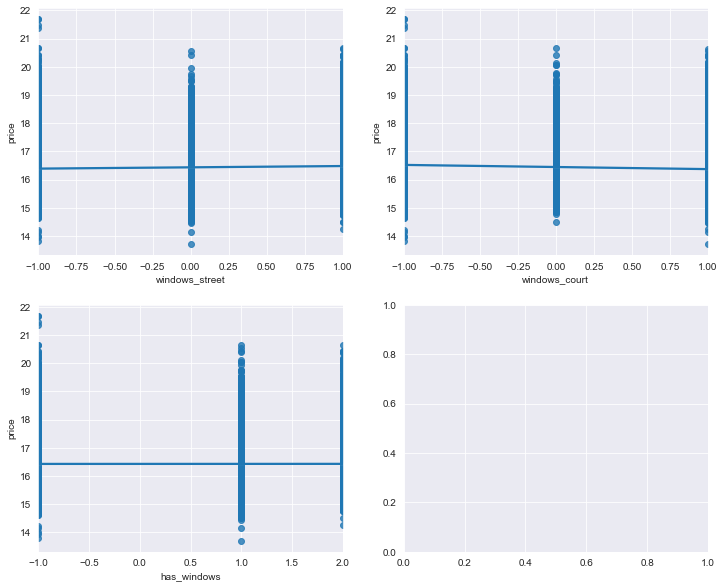

In [232]:
featured = preprocessor.combine_windows(featured.copy())
visualizer.corr_target(featured, cols=["windows_street", "windows_court", "has_windows"], target='price')

This feature does not correlate anything to the price - or at least very minimal. This is not something we want to add to our algorithm. Can we instead of making a categorical feature try to make a boolean one - describing whether or not any of the two types of windows exist? We will look at unknown as *false*.

                windows_street  windows_court  has_windows     price
windows_street        1.000000       0.714756     0.865483  0.042730
windows_court         0.714756       1.000000     0.936012 -0.079195
has_windows           0.865483       0.936012     1.000000 -0.081832
price                 0.042730      -0.079195    -0.081832  1.000000


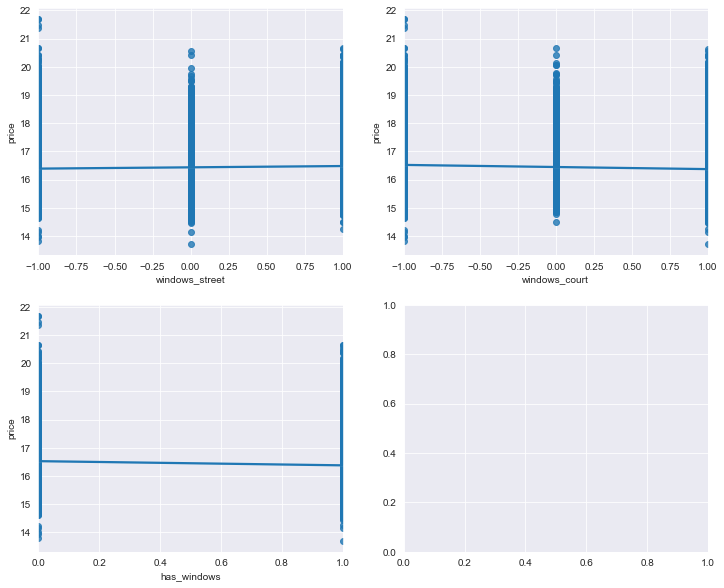

In [233]:
featured = preprocessor.combine_windows(featured.copy(), boolean=True)
visualizer.corr_target(featured, cols=["windows_street", "windows_court", "has_windows"], target='price')

This is better, but it is still a correlation of less than **0.1** to price. All these features are eligable for removal later, but we will leave them for now.

Now lets go over to one we know will have impact. We discussed this earlier when talking about *latitude* and *longitude*. We will now combine these features into a new one - **distance_center**. This will be calculated as the distance in km to the [*red square*](https://en.wikipedia.org/wiki/Red_Square) in the very heart of Moscow. 

                 latitude  longitude  distance_center     price
latitude         1.000000   0.082535        -0.430500  0.162631
longitude        0.082535   1.000000        -0.388759 -0.067534
distance_center -0.430500  -0.388759         1.000000 -0.528687
price            0.162631  -0.067534        -0.528687  1.000000


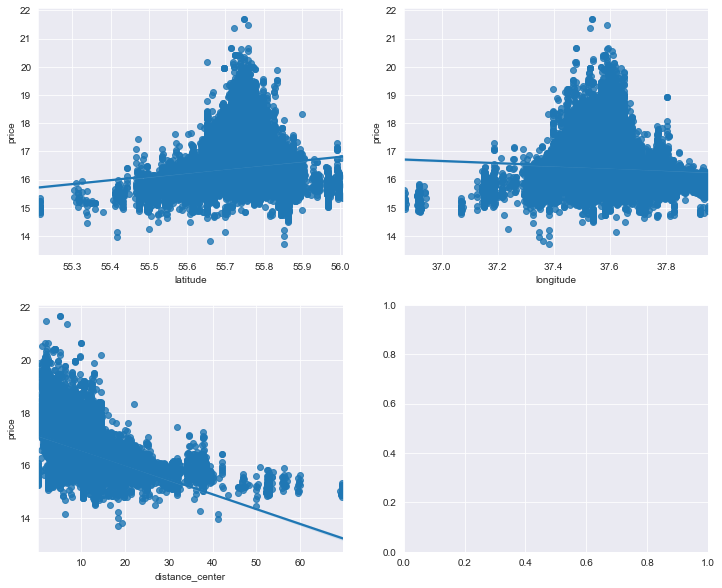

In [234]:
featured = preprocessor.combine_latlon(featured.copy())
visualizer.corr_target(featured, cols=["latitude", "longitude", "distance_center"], target='price')

As we thought. This feature has a very negative correlation to the price - meaning that when the *distance_center* feature is lower, the price gets higher. This, of course, makes sense, as apartments closer to the city center is ofter much more expensive. Lets plot this feature correlating to price.

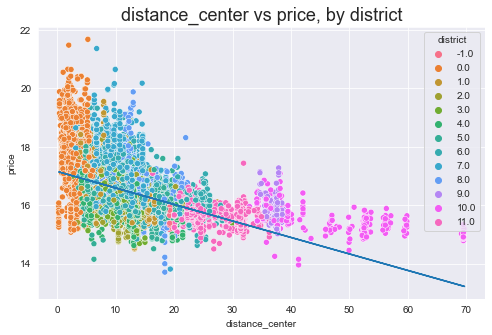

In [235]:
visualizer.plot_vs(featured[:23285].copy(), "distance_center", "price", reg=True, figsize=(8,5), hue="district")

The trend is very clear, and when using the district as the hue, we can clearly see how far the districts are away from the center as well - on a general basis. Lets now plot a new correlation grid to see how far we have come.


We remove the features: *garbage_chute*, *phones*, *has_windows*, *windows_street* and *windows_court*

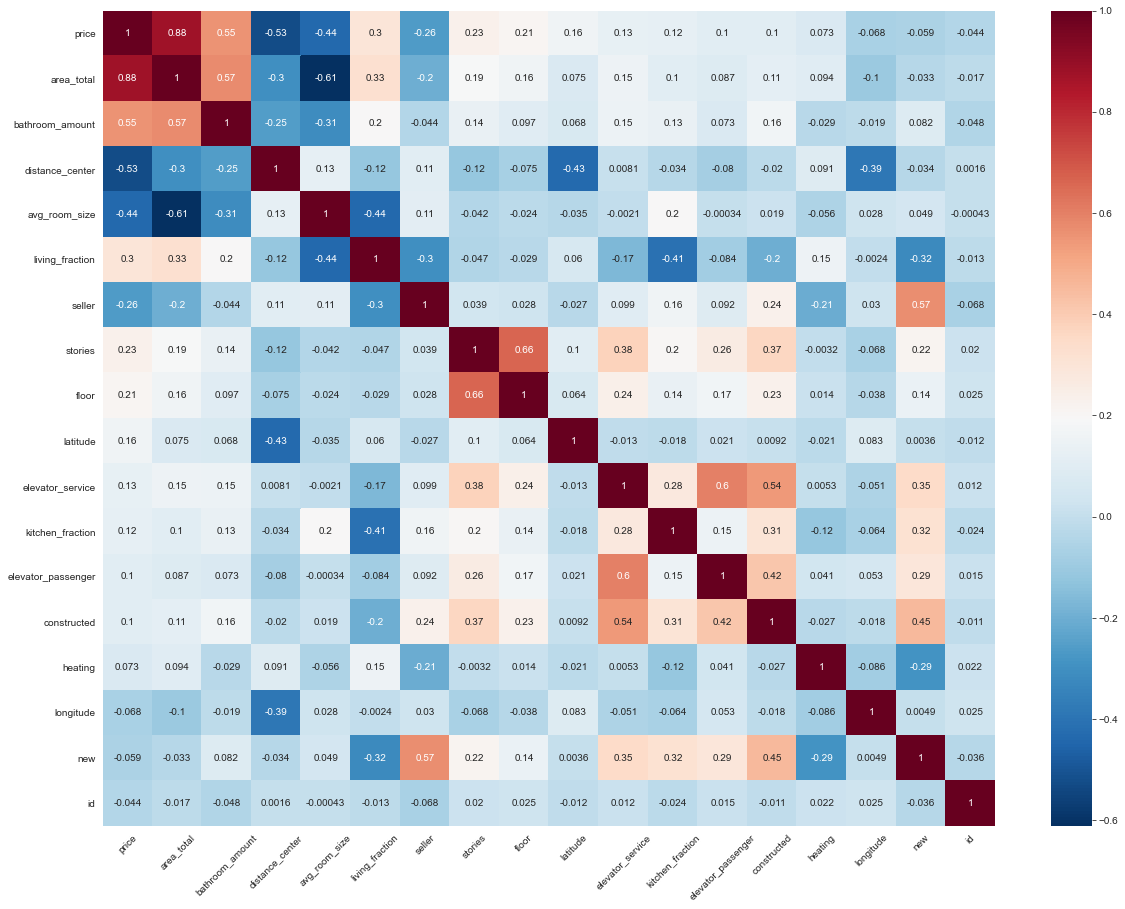

In [236]:
featured = preprocessor.remove_labels(featured.copy(), ["garbage_chute", "phones", "has_windows", "windows_street", "windows_court"])
visualizer.price_correlation(featured)

This has changed a lot. We have fewer features correlating to eachother, and more that correlate to price in a more impactful manner. However, there are a lot of features with below 0.1 correlation to price. We have now remove all those who does neither have a correlation higher than **0.1** to the price, or reasonable correlation to another feature. We do this because those features are not eligable for creating a new feature, nor being standalone.

The next thing we will look at is the elevator features. We will try combine these into a *has_elevator* feature, which, much like the windows, will tell if a building has both types of elevator, just one, or none. 

                    elevator_passenger  elevator_service     price
elevator_passenger            1.000000          0.602908  0.104824
elevator_service              0.602908          1.000000  0.125532
price                         0.104824          0.125532  1.000000


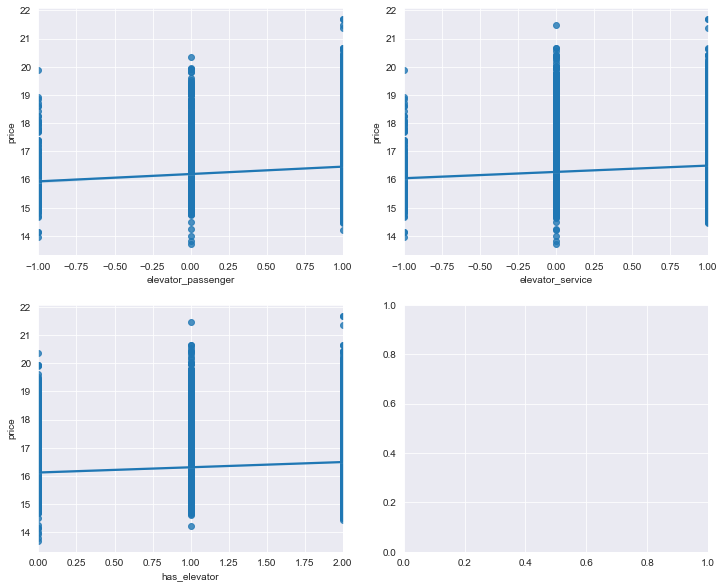

In [237]:
featured = preprocessor.combine_elevators(featured.copy())
visualizer.corr_target(featured, cols=["elevator_passenger", "elevator_service", "has_elevator"], target='price')

This feature does not really do that much, but it combines the two into a feature better than anyone of them on their own. We will remove the two other features and replace it with this, simplifying the data.

In [238]:
featured = preprocessor.remove_labels(featured.copy(), ["elevator_passenger", "elevator_service"])
featured.head()

,id,seller,price,area_total,floor,condition,building_id,new,latitude,longitude,district,constructed,material,stories,parking,heating,avg_room_size,living_fraction,kitchen_fraction,bathroom_amount,distance_center,has_elevator
0,0,3.0,15.781156,4.097672,2.0,-1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,-1.0,0.512209,0.845782,0.635163,2.0,25.022080,2
1,1,-1.0,16.166886,4.488636,18.0,3.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,0.0,0.166246,0.867038,0.606263,2.0,12.267029,2
2,2,3.0,16.014916,4.375757,12.0,-1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,-1.0,0.162065,0.853086,0.721475,2.0,12.060134,2
3,3,-1.0,16.166886,4.488636,18.0,2.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,0.0,0.166246,0.867038,0.603312,2.0,12.267029,2
4,4,-1.0,16.447399,4.369448,7.0,3.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,0.0,0.546181,0.820131,0.661496,1.0,21.041782,2


Now lets look at two features that should correlate a lot - namely *new* and *constructed*. There is no reason having both these in the dataset, as the year of construction should tell us if the apartment is new or not. Let plot these against each other and have a look.

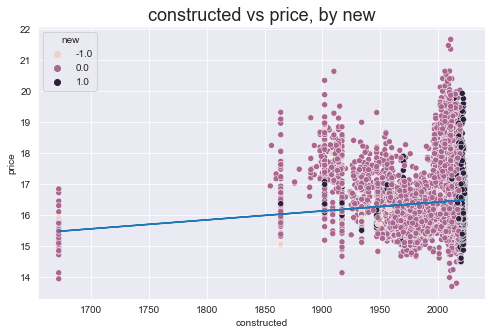

In [239]:
visualizer.plot_vs(featured[:23285].copy(), "constructed", "price", reg=True, figsize=(8,5), hue="new")

This does show something interesting - outliers exist. There are actually multiple apartments constructed before 2000 which as considered new. This is of course wrong. We will alter the *new* feature to be true when the apartment was buildt after 2018, else false. Lets see what this does.

                  new  constructed     price
new          1.000000     0.513370 -0.124977
constructed  0.513370     1.000000  0.103806
price       -0.124977     0.103806  1.000000


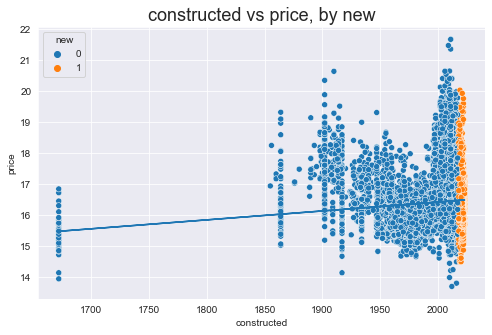

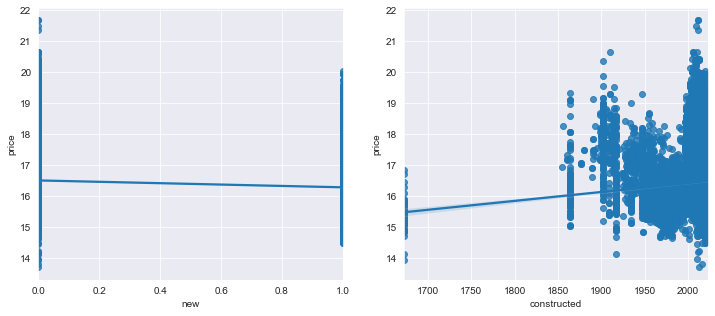

In [240]:
featured = preprocessor.redo_new(featured.copy())
visualizer.plot_vs(featured[:23285].copy(), "constructed", "price", reg=True, figsize=(8,5), hue="new")
visualizer.corr_target(featured, cols=["new", "constructed",], target='price')

This gives a sizable improvement to the *new* feature, but it is of course dependent on the construction year. As we discussed earlier in the exploration phase, the construction year did now really have the impact one might think on the price. When altering the *new* feature based on the actual construction year, we have "merged" these features together. Therefore - we will drop the *constructed* feature, and keep the *new* feature.

Lets once again look at the correlation grid. We will now look further into how can use the new and old features to improve the dataset.

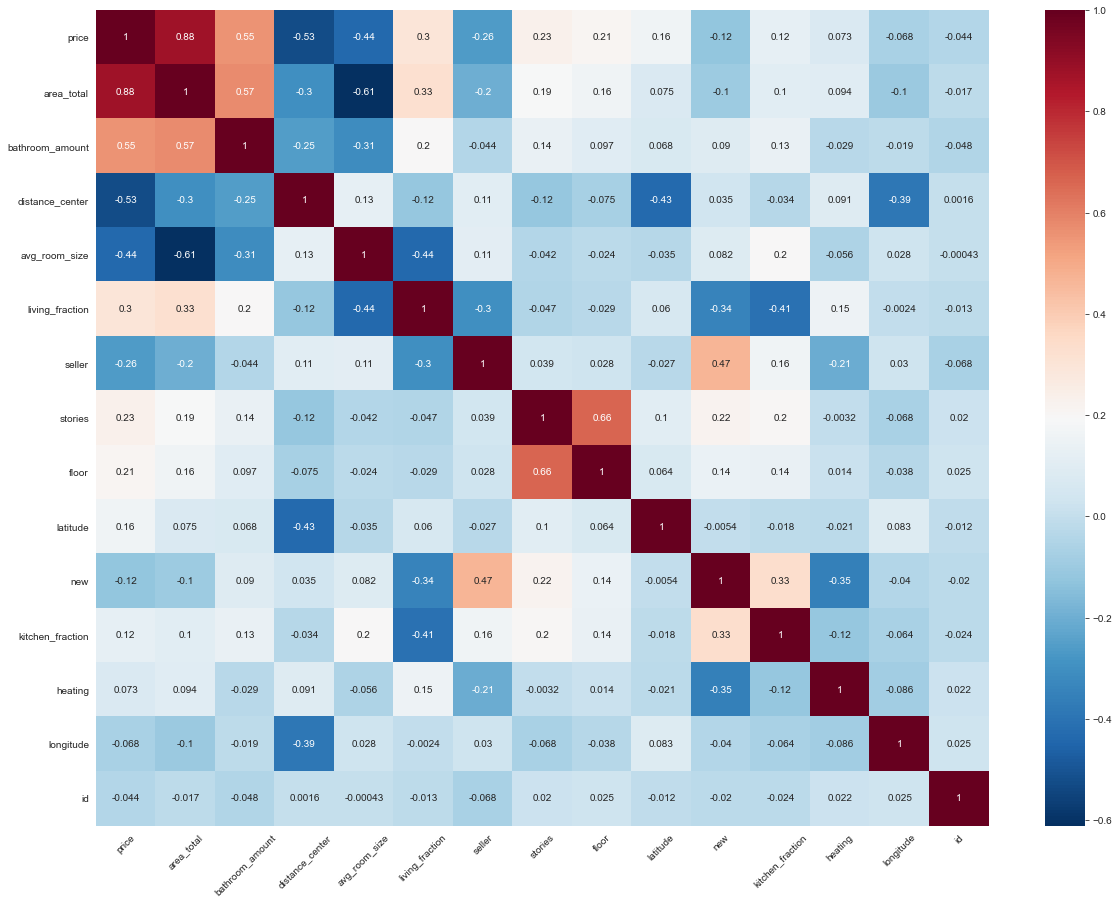

In [241]:
featured = preprocessor.remove_labels(featured.copy(), ["constructed"])
visualizer.price_correlation(featured)

Lets make a strategy.<br>
We see that *floor* and *stories* has a very high correlation. We should try to find something to do about this.<br>
We see that the *latitude* is much more impactful than the *longitude* when it comes to both *price* and *distance_center*. We will look into how we either remove *latitude* and/or *longitude*, or if we need to do something else with them.

In [242]:
categorical = featured.copy()
print("Number of features so far:", categorical.shape[1])

Number of features so far: 21


## Trying different models

There exists multiple different machine learning models to use for different problems. Which one to choose it not trivial, and often leads to trying different. With trial and error, we will be able to find a model which suits our needs when it comes to the problem at hand. In this section, we will discuss 4 models we have used in this project. We will train them, compare them, and evaluate them, hopefully leading to us finding a model we want to develop further with error analysis and more detailed hyperparameter tuning. 

We will start by seperating the data into training and testing data. Remember that we joined these into the same DataFrame to secure a uniform preprocessing phase. Now, we will split them again. We will also have to remove the price for the training data, adding these into its own *labels* variable. We will also split the training data into actual training and validation data. The validation set will be set to 30% of the training data. All this is done below, before we feed this into the models.

In [243]:
# Seperating training and test data
train_data = categorical[:23285].copy()
labels = train_data["price"]
test_data = categorical[23285:].copy()
test_data.drop("price", 1, inplace=True)
print("Split data into train and test")

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.3)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
x_train.drop("id", 1, inplace=True)
x_test.drop("id", 1, inplace=True)
print("Validation data created and price dropped")
print("The number of features are now:", x_train.shape[1])

# Initializing general model
general_model = TestModel(x_train, y_train)
test_labels = np.round([np.expm1(lab)for lab in y_test])

Split data into train and test
Validation data created and price dropped
The number of features are now: 19


### MLP

We start this section by discussing the first model we tried at the start of this project - namely the ***MLP*** model by using *KerasRegressor*.

In [244]:
mlp_model = general_model.keras_mlp_model(epochs=20, batch_size=10, verbose=1)
print("Training MLP model...")
pipeline_mlp = mlp_model.fit(x_train, y_train)
test_pred_mlp = np.round([np.expm1(pred) for pred in mlp_model.predict(x_test)])
print("Training complete \n")
print("RMLSE for MLP model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_mlp))

Training MLP model...
Epoch 1/20
1630/1630 [==============================] - 1s 669us/step - loss: 0.0830
Epoch 2/20
1630/1630 [==============================] - 1s 670us/step - loss: 0.0243
Epoch 3/20
1630/1630 [==============================] - 1s 665us/step - loss: 0.0194
Epoch 4/20
1630/1630 [==============================] - 1s 673us/step - loss: 0.0175
Epoch 5/20
1630/1630 [==============================] - 1s 694us/step - loss: 0.0163
Epoch 6/20
1630/1630 [==============================] - 1s 693us/step - loss: 0.0159
Epoch 7/20
1630/1630 [==============================] - 1s 688us/step - loss: 0.0147
Epoch 8/20
1630/1630 [==============================] - 1s 678us/step - loss: 0.0144
Epoch 9/20
1630/1630 [==============================] - 1s 667us/step - loss: 0.0141
Epoch 10/20
1630/1630 [==============================] - 1s 725us/step - loss: 0.0135
Epoch 11/20
1630/1630 [==============================] - 1s 687us/step - loss: 0.0133
Epoch 12/20
1630/1630 [==================

This initial MLP model with layers structured as this: **64, 128, 128, 64, 1**. Where each number represents the number of nodes in each network gives a RMSLE far above what we want on the validation set. This is of course with no hyperparameter tuning. Lets plot the predictions and the actual labels on the same graph and discuss what we see.

Mean error for MLP model: 5697400.849126825 rubels


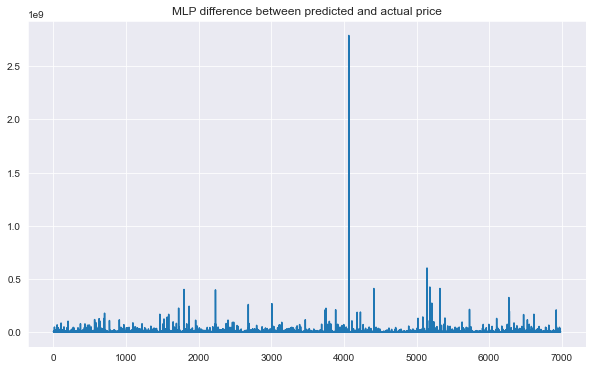

In [245]:
mlp_diff = abs(test_pred_mlp - test_labels)
print("Mean error for MLP model:", mlp_diff.mean(), "rubels")
visualizer.error_plot(mlp_diff, "MLP difference between predicted and actual price")

Keep in mind that the models might be slightly different when changing the train and validation split. This is because it not train on the same data as last time. It should, however, stay around the same area, making it possible to generalize. 

We see that the mean error - the actual mean price difference between the predictions and the labels - is very high, leading to a high RMSLE as well. If the number is positive, it means that this model overestimates the price, guessing it is worth more than it actually is, and vice versa. In these graphs, we will use absolute value to find out how large difference is, ignoring if it is negative or positive. We will not try to futher improve the *MLP* model, as it does not perform well enough for us to use more time on it. 

Lets instead turn our heads towards another model - namely *RandomForest*.

### RandomForest

We will not be using tuned hyperparameters for this one either. **RandomForest** is notorious for overfitting, and we will be cautious of this when tuning models. This snippet is just to see if the base model itself will preform better than the previous *MLP* model.

In [246]:
rf_model = general_model.randomforest_model()
print("Training RF model...")
pipeline_rf = rf_model.fit(x_train, y_train)
test_pred_rf = np.round([np.expm1(pred) for pred in rf_model.predict(x_test)])
print("Training complete \n")
print("RMLSE for RF model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_rf))

Training RF model...
Training complete 

RMLSE for RF model: 0.16446738534336777


Needless to say, this looks much more promising than with *MLP*. Keep in mind that this is without any hyperparameter tuning - just a clean constructor with default values. Lets again plot the difference and discuss it.

Mean error for RF model: 4008215.6527340394 rubels


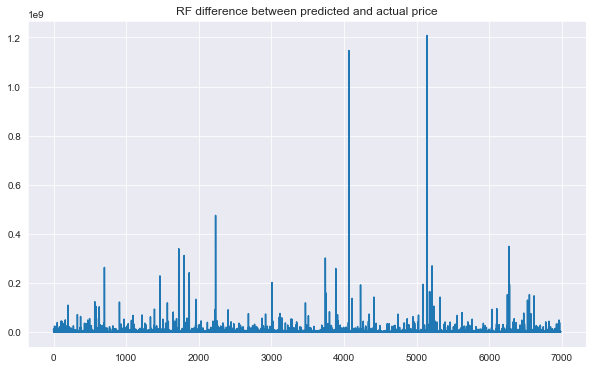

In [247]:
rf_diff = abs(test_pred_rf - test_labels)
print("Mean error for RF model:", rf_diff.mean(), "rubels")
visualizer.error_plot(rf_diff, "RF difference between predicted and actual price")

We see that the mean error for this model is lower - which is good. It has a significantly lower RMSLE, which makes sense. Because of this good initial score, we will keep the RandomForest model fresh in our minds when it comes to tuning the model even more.

Lets continue with **XGBoost**

### XGBoost

XGBoost is a model which is known for being very sensitive to hyperparameter tuning. This means that the success of a model might be vastly different depending on the hyperparameters provided in the constructor. We will, once again, just use the base model for this simple comparison - getting an idea of where this model lies when it comes to out dataset.

In [248]:
boost_model = general_model.xgboost_model()
print("Training XGBoost model...")
pipeline_boost = boost_model.fit(x_train._get_numeric_data(), y_train)
test_pred_boost = np.round([np.expm1(pred) for pred in boost_model.predict(x_test._get_numeric_data())])
print("Training complete \n")
print("RMLSE for XGBoost model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_boost))

Training XGBoost model...
Training complete 

RMLSE for XGBoost model: 0.1631179999733059


Not bad. It performs around the same as *RandomForest* does (a bit better), making it worth tuning later on. Lets plot the data.

Mean error for RF model: 4062923.734182651 rubels


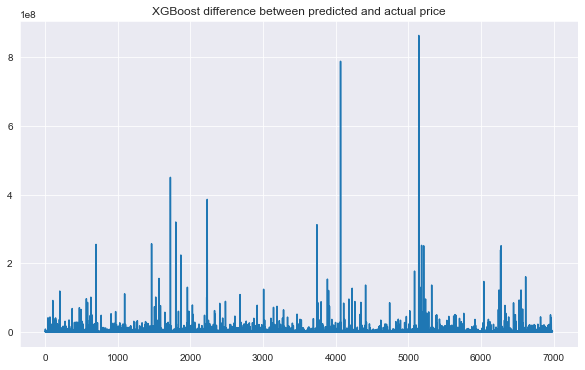

In [249]:
boost_diff = abs(test_pred_boost - test_labels)
print("Mean error for RF model:", boost_diff.mean(), "rubels")
visualizer.error_plot(boost_diff, "XGBoost difference between predicted and actual price")

It seems like *XGBoost* and *RandomForest* has something else in common. They seem to predict very wrong on the same apartments. These graphs are almost exactly the same. We have to look into what is so special about these apartments. For now though, we will look at tuning both *RandomForest* and *XGBoost*, but will not think any more about the *MLP* model.

Lets finish the initial trial of models by testing the **LGBM** model.

### LGBM

*LightGBM* was developed by microsoft as a alternative model for solving machine learning problems. We will once again try the default constructor to see if it can be a contender for helping us achieve the goal of finding the best predictions for houses and apartments in Moscow.

In [250]:
lgbm_model = general_model.lgbm_model()
print("Training LGBM model...")
pipeline_lgbm = lgbm_model.fit(x_train, y_train)
test_pred_lgbm = np.round([np.expm1(pred) for pred in lgbm_model.predict(x_test)])
print("Training complete \n")
print("RMLSE for LGBM model: %s" % general_model.root_mean_squared_log_error(test_labels, test_pred_lgbm))

Training LGBM model...
Training complete 

RMLSE for LGBM model: 0.1613970115100411


This RMSLE is on par with both *RF* and *XGBoost*. We have to keep in mind that we have not done any tuning, but just used the standard constructor. We think this value is good enough for developing the model further, and it is still in the running. Lets plot the data and see what it shows us.

Mean error for RF model: 4236715.8464071 rubels


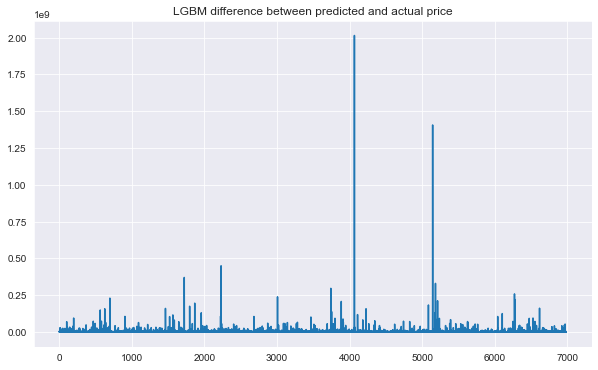

In [251]:
lgbm_diff = abs(test_pred_lgbm - test_labels)
print("Mean error for RF model:", lgbm_diff.mean(), "rubels")
visualizer.error_plot(lgbm_diff, "LGBM difference between predicted and actual price")

We see that this model has a larger mean error than the other two - which is also reflected in the RMSLE. This comes from the huge spikes in error. As we discussed earlier, we will have to look at the apartments the models are very wrong about, and what makes them special. We believe that LGBM is good enough for now to keep.

Now, lets go over to tuning some parameters

## Tuning hyperparameters

In this section, we will come back to the models we used in the previous section. We will use *GridSearchCV*, to feed the models different ranges of hyperparameters to try, and return the best combination of these. This process will take time. Because of this, we have created files for each of the models you can load the best configuration from if you want. If not, you are free to run the actual search yourself. To load from file, just put `load=True` as a parameter into the `start_xxx_search` function calls.

### AutoML

Later in this notebook, we will discuss AutoML and how we used it to find models for solving the problem. We will combine and compare the models discussed above, but also some other popular choices when it comes to these sorts of problems. Finding the best model with AutoML takes a lot more time than just running the models straight up (as we have up until this point). We will discuss AutoML in the last part of this section, and it might be the way we go when it comes to choosing the models and hyperparameters

### RandomForest hyperparameter search

*RandomForest* is a model where hyperparameters are very important. Because of this, we will create a grid with a fair amount of different parameters, making the probability of finding a good model higher, but using more time. Below you can see the parameter grid we will be using for this model.


In [252]:
params_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 220, 240, 260, 300, 320, 350]}

This will lead to `2 * 11 * 2 * 3 * 3 * 10 = 3960` different candidates of the *RandomForest* model - which would take ages if we were to to it manually. Lets start the search (keep in mind you can use `load=True` to load the best one from file).

In [253]:
rf_search = general_model.start_rf_search(params_rf, load=True)
rf_best = rf_search.fit(x_train, y_train)
test_pred_tuned_rf = np.round([np.expm1(pred) for pred in rf_best.predict(x_test)])
print("RMSLE for tuned RF model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred_tuned_rf))
rf_best

RMSLE for tuned RF model: 0.15754981764097906



RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      n_estimators=300)

Better when compared to the initial *RandomForest* model we tried. Lets continue with *XGBoost*.

### XGBoost hyperparameter search

*XGBoost* is a another model where hyperparameters are very important. We use the same way to search the parameter grid, but of course, with new parameters.

In [254]:
params_boost = {'nthread':[4],
              'objective':['reg:squarederror'],
              'learning_rate': [.05, .14, .2, .3],
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [1, 2, 4, 6],
              'subsample': [.7, 1, .6, .5],
              'colsample_bytree': [.7, .5, 0.3],
              'n_estimators': [50, 100, 200, 300, 500]}

This will lead to `1 * 1 * 4 * 4 * 4 * 4 * 3 * 5 = 3840` different candidates of the *XGBoost* model. You can start the search below.

In [255]:
boost_search = general_model.start_xgboost_search(params_boost, load=True)
boost_best = boost_search.fit(x_train._get_numeric_data(), y_train)
test_pred_tuned_boost = np.round([np.expm1(pred) for pred in boost_best.predict(x_test._get_numeric_data())])
print("RMSLE for tuned XGBoost model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred_tuned_boost))
boost_best

RMSLE for tuned XGBoost model: 0.1506670834581736



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.14, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.6, tree_method='exact', validate_parameters=1,
             verbosity=None)

This improvement is actually somewhat sizeable. It shows that *XGBoost* is a strong contender for being an algorithm able to solve this sort of problem. Lets continue with *LGBM*.

### LGBM hyperparameter search

We do the same thing as with the other two, but this time on the *LGBM* model.

In [256]:
params_lgbm = {
    'learning_rate': [0.005, 0.01, 0.003],
    'n_estimators': [50, 100, 200, 500, 1000],
    'num_leaves': [6, 8, 12, 16],
    'boosting_type' : ['gbdt', 'dart', 'goss'],
    'objective': ['regression'],
    'metric': ['rmse'],
    'colsample_bytree' : [0.5, 0.6],
    'subsample' : [0.7, 0.75],
    'reg_alpha' : [1, 1.2],
    'reg_lambda' : [1, 1.2, 1.4]}

This will lead to `3 * 5 * 4 * 3 * 1 * 1 * 2 * 2 * 2 * 3 = 4320` different candidates of the *LGBM* model. 

In [257]:
lgbm_search = general_model.start_lgbm_search(params_lgbm, load=True)
lgbm_best = lgbm_search.fit(x_train, y_train)
test_pred_tuned_lgbm = np.round([np.expm1(pred) for pred in lgbm_best.predict(x_test)])
print("RMSLE for tuned LGBM model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred_tuned_lgbm))
lgbm_best

RMSLE for tuned LGBM model: 0.17767402341476074



LGBMRegressor(boosting_type='goss', colsample_bytree=0.6, learning_rate=0.01,
              metric='rmse', n_estimators=1000, num_leaves=16,
              objective='regression', reg_alpha=1, reg_lambda=1, subsample=0.7)

Okay. So this one is far worse than the initial one. This might be because we have chosen the wrong range of parameters for this problem.

We will keep *RandomForest*, *XGBoost* and *LGBM* when we start using *AutoML*. It should be able to find models in a much more efficient manner than *GridSearchCV*. Lets look at this now.

### AutoML

*GridSearchCV* can be a very nice way of finding good hyperparameters for a model. Another way of doing this is to use something called **AutoML**. These kinds of algoritms will automatically try different models and tune them for the problem. It will run a set amount of time, or until it converges, and return the best model it found during execution. Keep in mind that this is based on training loss, which can be significantly less than the validation and test loss. We will run Microsofts AutoML algorithm *flaml*, and tell it to try the three different models discussed above. Maybe it will be able to find something better than we already have. After this, we will analyze the error to see where our algorithm is guessing wrong. Maybe some features are too influential, or not influencial enough? 

In [258]:
general_model.autoMLfit(x_train, y_train, time=60)

[flaml.automl: 11-19 03:39:25] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:39:25] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:39:25] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:39:25] {1577} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'rf']
[flaml.automl: 11-19 03:39:25] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-19 03:39:25] {1943} INFO - Estimated sufficient time budget=1035s. Estimated necessary time budget=1s.
[flaml.automl: 11-19 03:39:25] {2023} INFO -  at 0.2s,	estimator xgboost's best error=0.9157,	best estimator xgboost's best error=0.9157
[flaml.automl: 11-19 03:39:25] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-19 03:39:25] {2023} INFO -  at 0.3s,	estimator lgbm's best error=0.0364,	best estimator lgbm's best error=0.0364
[flaml.automl: 11-19 03:39:25] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-19 03:39:25] {2

In [259]:
test_pred_auto = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])

auto_df = pd.DataFrame([(test_labels[i], test_pred_auto[i]) for i in range(len(test_pred_auto))], columns=["actual", "prediction"])
print("RMSLE for AutoML model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred_auto))
general_model.autoML_print_best_model()

RMSLE for AutoML model: 0.1381665745014763

best model lgbm
configs {'n_estimators': 5643, 'num_leaves': 20, 'min_child_samples': 26, 'learning_rate': 0.02140229050483229, 'log_max_bin': 7, 'colsample_bytree': 0.5193725050488697, 'reg_alpha': 0.0010875605097862842, 'reg_lambda': 0.23744028525787908}


As we can see, *AutoML* tries a lot of models quickly. To get the most out if this, we should let it run for some time. This way, the probability of it finding a better model increases. 

Even though we have added, altered and removed features to the dataset - this part of the work it not done. We will now have a second go at feature engineering, mainly focusing on the distance to different landmarks, hospitals, schools and more around moscow. Our idea is that this should make the model better, as real estate is all about: *Location! Location! Location*. Before we do this however, lets see on what kind of aparments the best model *AutoML* found erred the most. This will help us in understanding where we need to finetune the model to get the best result possible.

## Analyzing the error

In this section we will dive into and try to find out where our models go wrong. Getting the price perfect for all the apartments is a utopian dream, and is of course not practically possible. However, we should be able to get a better result than we already have. For this, we need to analyze the error. We will try to find out the kind of apartments our model overestimates, and underestimates, and what they have in common. This will make it possible for us to find out if the features we have created behaves the way we want, or if they are silently hurting the performance. Lets start by plotting the mean error for the best *AutoMl* model.

Mean error for AutoML model: 3692898.118236473 rubels


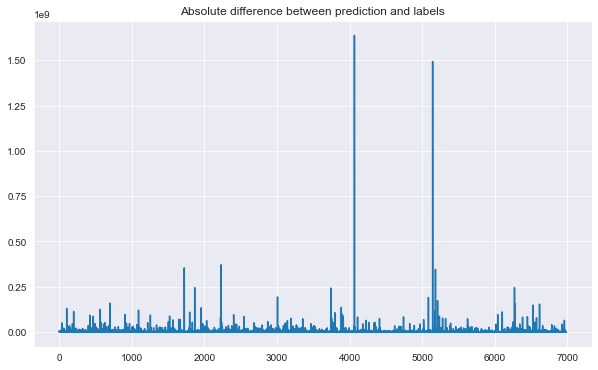

In [260]:
auto_diff = abs(test_pred_auto - test_labels)
print("Mean error for AutoML model:", auto_diff.mean(), "rubels")
visualizer.error_plot(auto_diff, "Absolute difference between prediction and labels")

Once again we see tall spikes, meaning that the model was far off. For one of these, the model missed by around *600 million* rubels, which is way too much to get the performance we want. Lets plot the actual error(not absolute value) to see if we can discover something

Mean actual error: -998681.2144288577


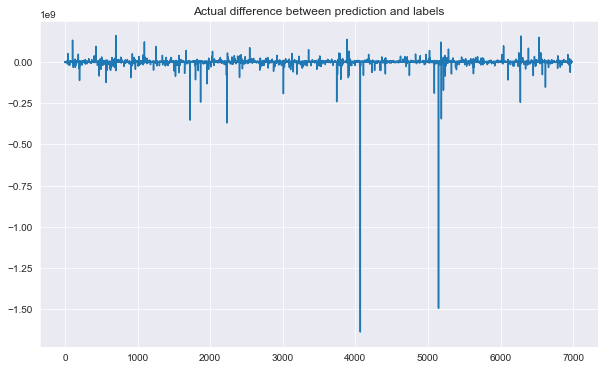

In [261]:
diff = test_pred_auto - test_labels
print("Mean actual error:", diff.mean())
visualizer.error_plot(diff, "Actual difference between prediction and labels")

This shows us that the model does not only guess wrong "one way". It both over- and underestimates apartments. As the mean difference is negative, it means that it it more likely to underestimate ***or*** it underestimates a lot when it does so. Lets see how the model predicts the very expensive, middle, and very cheap apartments. The extremes on both sides can have a huge effect on performance, and we want to perform well across all price ranges.

We will start by finding the top 95%, low 95%, and those between the 45th and 55th percentile. For this, we will only use apartments from the training data - as we want to see the prices and how we predict them.

In [262]:
top_95 = train_data["price"].quantile(0.95)
low_5  = train_data["price"].quantile(0.05)
mid_45 = train_data["price"].quantile(0.45)
mid_55 = train_data["price"].quantile(0.55)

top = train_data[train_data["price"] > top_95]
low = train_data[train_data["price"] < low_5]
mid_temp = train_data[train_data["price"] > mid_45]
mid = mid_temp[mid_temp["price"] < mid_55]

top_mean = np.round(np.expm1(top["price"]).mean())
mid_mean = np.round(np.expm1(mid["price"]).mean())
low_mean = np.round(np.expm1(low["price"]).mean())
                    
print("Mean price top 95%:", top_mean, "rubels")
print("Mean price mid 10%:", mid_mean, "rubels")
print("Mean price low  5%:", low_mean, "rubels")
top_labels = top["price"]
mid_labels = mid["price"]
low_labels = low["price"]

top = preprocessor.remove_labels(top.copy(), "price")
mid = preprocessor.remove_labels(mid.copy(), "price")
low = preprocessor.remove_labels(low.copy(), "price")

Mean price top 95%: 170380311.0 rubels
Mean price mid 10%: 10681944.0 rubels
Mean price low  5%: 4294333.0 rubels


Lets feed these into the model and see how it predicts the prices for these apartments.

In [263]:
# Top
test_pred_top = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(top)])
test_labels_top = np.round([np.expm1(lab)for lab in top_labels])

# Mid
test_pred_mid = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(mid)])
test_labels_mid = np.round([np.expm1(lab)for lab in mid_labels])

# Low
test_pred_low = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(low)])
test_labels_low = np.round([np.expm1(lab)for lab in low_labels])

print("RMSLE TOP: %s" % general_model.root_mean_squared_log_error(test_labels_top, test_pred_top))
print("RMSLE MID: %s" % general_model.root_mean_squared_log_error(test_labels_mid, test_pred_mid))
print("RMSLE LOW: %s" % general_model.root_mean_squared_log_error(test_labels_low, test_pred_low))

RMSLE TOP: 0.19013529383574146
RMSLE MID: 0.07286279477976465
RMSLE LOW: 0.11690569031746299


Mean error on top 95%: -12525622.0 rubels
Mean absolute error on top 95%: 23992367.0 rubels
The error is 0.1408 times the mean price


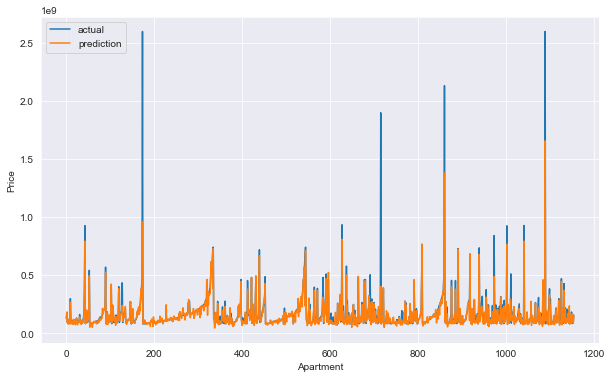

In [264]:
top_df = pd.DataFrame({ "actual": test_labels_top, "prediction": test_pred_top}, index=range(0, 1155))
top_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
top_diff = test_pred_top - test_labels_top
print(f"Mean error on top 95%: {np.round(top_diff.mean())} rubels")
print(f"Mean absolute error on top 95%:", np.round(abs(test_pred_top - test_labels_top).mean()), "rubels")
print(f"The error is {np.round(abs(test_pred_top - test_labels_top).mean()/top_mean, 4)} times the mean price")

This shows that for the top 95% of apartments, we are underestimating the price by an average in the tens of millions. We see that for the apartments in the lower part of this percentile, the prediction seems to not be so bad. We can view this by changing the y-axis to give us a more detailed overview.

<AxesSubplot:xlabel='Apartment', ylabel='Price'>

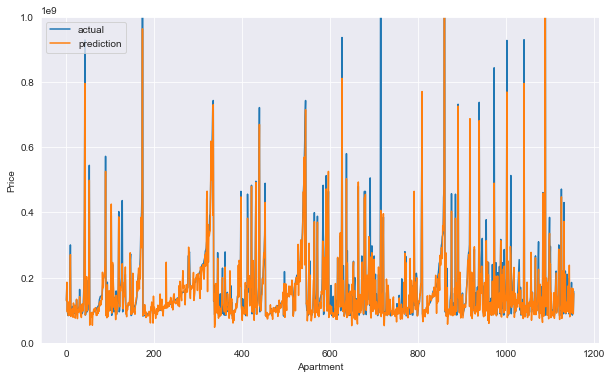

In [265]:
top_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment", ylim=(0, 1000000000))

This shows more detail. We can see that the predictions are not so bad. There are still places where the model predicts way more, or way less than it should, but for the most part, it seems like it is doing OK. We saw in the last graph (which is this one, it just has the y-axis limited) that the model on average underestimates the price for these expensive apartments. This also seems to be the case for these lower-end high-end apartments. We see a lot of blue above the orange, meaning that the prediction did not reach the actual price. Lets find the top 5% of apartments where the erred the most and see what they are like.

In [266]:
top_error = top_df.copy()
top_error["id"] = list(top["id"])
top_error["diff"] = abs(top_error["prediction"] - top_error["actual"])
top_error = top_error[top_error["diff"] > top_error["diff"].quantile(0.95)]
print("Amount:", len(top_error))
top_error.head()

Amount: 58


,actual,prediction,id,diff
42,928585500.0,795146480.0,2468,133439020.0
126,433339900.0,188740703.0,3059,244599197.0
127,436050000.0,242472884.0,3060,193577116.0
146,272385080.0,197355073.0,3102,75030007.0
151,94500000.0,213273125.0,3137,118773125.0


In [267]:
unlogged = data.copy()
unlogged["price"] = np.expm1(unlogged["price"])
unlogged["area_total"] = np.expm1(unlogged["area_total"])
misfits_top = pd.DataFrame()
for _, row in top_error.iterrows():
    frame = pd.DataFrame(unlogged[unlogged["id"] == row["id"]])
    frame["prediction"] = row["prediction"]
    misfits_top = pd.concat([misfits_top, frame])
print("Amount:", len(misfits_top))
misfits_top

Amount: 58


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,prediction
2468,2468,-1.0,9.285855e+08,750.00,5.041526,6.023681,15.0,6.0,1.0,0.0,-1.0,-1.0,3.0,1.0,5410,0.0,55.713725,37.479061,7.0,2006.0,2.0,15.0,1.0,0.0,-1.0,-1.0,0.0,7.951465e+08
3059,3059,-1.0,4.333399e+08,233.00,3.886732,4.860003,6.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,906,0.0,55.757131,37.617114,0.0,2015.0,2.0,15.0,1.0,1.0,0.0,1.0,-1.0,1.887407e+08
3060,3060,-1.0,4.360500e+08,306.00,4.154373,5.130699,7.0,5.0,4.0,0.0,-1.0,-1.0,-1.0,1.0,3979,0.0,55.741130,37.577597,0.0,1902.0,-1.0,7.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.424729e+08
3102,3102,-1.0,2.723851e+08,158.00,3.044522,4.709530,3.0,3.0,2.0,0.0,1.0,1.0,3.0,2.0,3451,0.0,55.737314,37.600891,0.0,2006.0,0.0,6.0,1.0,1.0,0.0,-1.0,0.0,1.973551e+08
3137,3137,-1.0,9.450000e+07,290.00,3.044522,5.398163,6.0,6.0,4.0,0.0,0.0,1.0,3.0,2.0,4122,0.0,55.751457,37.577355,0.0,1998.0,0.0,17.0,1.0,1.0,-1.0,1.0,0.0,2.132731e+08
3157,3157,-1.0,4.023871e+08,311.00,3.258097,5.442418,3.0,5.0,4.0,0.0,1.0,1.0,3.0,2.0,6966,0.0,55.721863,37.571390,0.0,2015.0,-1.0,8.0,0.0,1.0,0.0,1.0,0.0,2.918590e+08
3217,3217,-1.0,2.600000e+09,2181.00,6.104741,7.089557,95.0,6.0,1.0,1.0,-1.0,-1.0,1.0,1.0,5745,0.0,55.749511,37.537083,0.0,2011.0,2.0,95.0,1.0,1.0,0.0,1.0,0.0,9.625045e+08
3452,3452,-1.0,1.114303e+08,445.00,3.044522,4.948760,5.0,1.0,4.0,0.0,1.0,1.0,2.0,2.0,4181,0.0,55.764090,37.608562,0.0,1917.0,0.0,6.0,1.0,0.0,-1.0,0.0,0.0,2.470508e+08
3529,3529,-1.0,2.190000e+08,152.00,3.397858,4.178992,4.0,3.0,1.0,0.0,-1.0,-1.0,2.0,1.0,1621,0.0,55.761983,37.614213,0.0,2007.0,0.0,6.0,1.0,0.0,-1.0,-1.0,0.0,1.359297e+08
3544,3544,-1.0,3.095285e+08,347.50,4.279676,5.523459,5.0,4.0,3.0,1.0,0.0,1.0,3.0,2.0,5723,0.0,55.738880,37.602005,0.0,2002.0,-1.0,5.0,1.0,0.0,0.0,-1.0,3.0,4.399037e+08


Okay. These are the top 58 of the top 95% (based on price) the model missed the most. We can see that most of them are large - which makes sense as these are the expensive ones. We also see that most of them are located in district 0, which is the one closest to the city center. Most of them also have multiple bathrooms, which makes sense for a large apartment. Lets try finding if there are some anomalies hiding here.

We have already discovered that the model more often than not underestimates the price of these expensive apartments. Why is that?

We see that the model thinks large apartments (houses) in the outside districts (far away from the center) are worth more than they actually are - and the opposite for large ones in the city core. It seems like it cares too much about how large the apartment is, and less where it is located. We can confirm this when looking at the correlation grid, where *area_total* is around *0.88* while *distance_center* is around *-0.53*. As stated earlier, real estate is "all about" location - and because of this, having just one distance feature seems to not do the trick for us. 

In this DataFrame we also see that apartments higher up in the buildings (penthouses) are usually worth significantly more than the model believes. This correlation between *floor* and *stories* is something we have touched on earlier, but it seems like we need to come back to the drawing board for this, as it will help sorting these errors out. 

Keeping this in mind, we will now look for anomalies in the low sector in our dataset. This part performed better than the top. This can be because the possible error for these are lower than the expensive ones (as the apartments are only worth so much), but we will se if we can find some systematic weirdness.

Mean error on low 95%: 178506.0 rubels
Mean absolute error on low 95%: 306681.0 rubels
The error is 0.0714 times the mean price


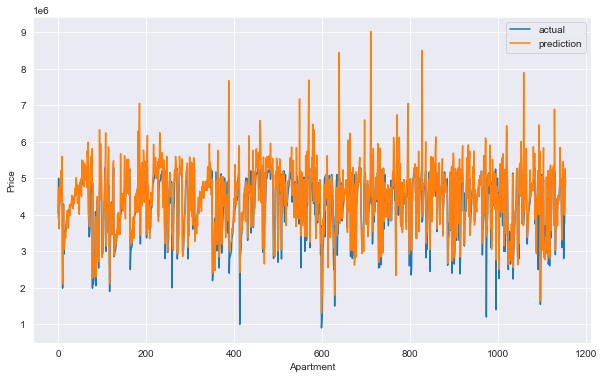

In [268]:
low_df = pd.DataFrame({ "actual": test_labels_low, "prediction": test_pred_low}, index=range(0, 1155))
low_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
low_diff = test_pred_low - test_labels_low
print(f"Mean error on low 95%: {np.round(low_diff.mean())} rubels")
print(f"Mean absolute error on low 95%:", np.round(abs(test_pred_low - test_labels_low).mean()), "rubels")
print(f"The error is {np.round(abs(test_pred_low - test_labels_low).mean()/low_mean, 4)} times the mean price")

This shows that for the lowest 5% of apartments, we are overestimating the price by an average in in the hundreds of thousands. This number is not that high, but we have to keep in mind that the prices are also lower. Many of these apartments cost less than the error we have for the higher end apartments. We also see that the error relative to the mean price of the set is lower than with the higher end apartments. We can be quite certain that the current model will perform better on lower end apartments than higher end ones. Lets look for anomalies.

In [269]:
low_error = low_df.copy()
low_error["id"] = list(low["id"])
low_error["diff"] = abs(low_error["prediction"] - low_error["actual"])
low_error = low_error[low_error["diff"] > low_error["diff"].quantile(0.95)]
print("Amount:", len(low_error))
low_error.head()

Amount: 58


,actual,prediction,id,diff
94,4700000.0,6328314.0,1723,1628314.0
99,3500000.0,4736891.0,1792,1236891.0
108,4600000.0,6241292.0,2110,1641292.0
114,4500000.0,5854616.0,2146,1354616.0
115,4800000.0,5854616.0,2147,1054616.0


In [270]:
misfits_low = pd.DataFrame()
for _, row in low_error.iterrows():
    frame = pd.DataFrame(unlogged[unlogged["id"] == row["id"]])
    frame["prediction"] = row["prediction"]
    misfits_low = pd.concat([misfits_low, frame])
print("Amount:", len(misfits_low))
misfits_low

Amount: 58


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating,prediction
1723,1723,-1.0,4700000.0,38.00,2.173360,3.085552,10.0,2.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,3594,-1.0,55.848913,37.586356,2.0,1956.0,-1.0,16.0,-1.0,-1.0,-1.0,-1.0,-1.0,6328314.0
1792,1792,1.0,3500000.0,20.00,1.629010,2.944439,12.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,4512,0.0,55.867041,37.709596,2.0,1980.0,3.0,16.0,1.0,1.0,1.0,-1.0,-1.0,4736891.0
2110,2110,1.0,4600000.0,39.00,2.196414,3.465736,13.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,1158,0.0,55.849221,37.586607,2.0,1980.0,-1.0,17.0,1.0,1.0,1.0,-1.0,-1.0,6241292.0
2146,2146,1.0,4500000.0,38.00,2.173360,3.044522,10.0,2.0,0.0,1.0,-1.0,-1.0,1.0,1.0,1158,0.0,55.849221,37.586607,2.0,1980.0,-1.0,17.0,1.0,1.0,1.0,-1.0,-1.0,5854616.0
2147,2147,1.0,4800000.0,38.00,2.173360,3.044522,10.0,2.0,0.0,1.0,-1.0,-1.0,1.0,1.0,1158,0.0,55.849221,37.586607,2.0,1980.0,-1.0,17.0,1.0,1.0,1.0,-1.0,-1.0,5854616.0
2248,2248,1.0,3950000.0,45.00,1.945910,3.433987,2.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,6854,0.0,55.785549,37.613575,2.0,1973.0,3.0,5.0,0.0,0.0,-1.0,-1.0,0.0,5672917.0
2257,2257,2.0,4400000.0,41.60,1.887070,3.370738,3.0,2.0,0.0,1.0,-1.0,-1.0,1.0,2.0,6734,0.0,55.625725,37.663351,5.0,1970.0,-1.0,3.0,0.0,0.0,1.0,-1.0,-1.0,5616715.0
2337,2337,2.0,4800000.0,32.30,1.945910,2.890372,8.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,7951,0.0,55.803125,37.784210,3.0,1977.0,3.0,12.0,1.0,0.0,-1.0,1.0,0.0,6294504.0
2339,2339,0.0,5050000.0,73.00,2.770130,3.716269,2.0,2.0,0.0,0.0,-1.0,-1.0,1.0,1.0,1368,0.0,55.419166,37.404142,10.0,2008.0,0.0,9.0,1.0,0.0,-1.0,1.0,0.0,6370371.0
2340,2340,-1.0,5150000.0,90.00,2.772589,3.891820,5.0,3.0,0.0,1.0,-1.0,-1.0,-1.0,0.0,2279,0.0,55.938375,37.525244,2.0,1956.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,-1.0,7048772.0


We see that the vast majority of these apartments have been overestimated. One thing in common for most of them is that they are quite small in size, and a small part of them are located in the city center. Intuitively this should mean lower price - which it does. What our model seems to not understand, is how much this should affect price drop. Many of the apartments are also quite old (around mid 1900s). We have already discussed that is does not look like the age of the apartment has as much to say as one might have you believe, but maybe it is more important than at first glance. We will keep this in mind.

The key takeaway from this is that the model seems to care too much about total area and not enough about distance, both when it comes to the high-end and the low-end apartments. Another reason to find more distance features. We will end this quick error analysis for this model by looking at the mid-range apartments - just to be sure it behaves like we believe it does.

Mean error on mid 10%: -15481.0 rubels
Mean absolute error on low 95%: 546193.0 rubels
The error is 0.0511 times the mean price


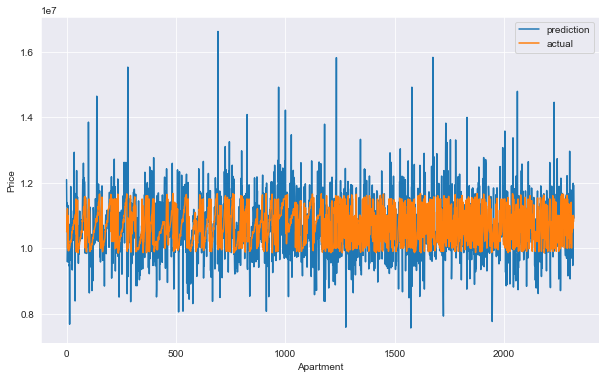

In [271]:
mid_df = pd.DataFrame({ "prediction": test_pred_mid,"actual": test_labels_mid}, index=range(0, 2319))
mid_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
mid_diff = test_pred_mid - test_labels_mid
print(f"Mean error on mid 10%: {np.round(mid_diff.mean())} rubels")
print(f"Mean absolute error on low 95%:", np.round(abs(test_pred_mid - test_labels_mid).mean()), "rubels")
print(f"The error is {np.round(abs(test_pred_mid - test_labels_mid).mean()/mid_mean, 4)} times the mean price")

For this one, we have changed the colors to give a better representation as the prediction is all over the place, while the actual prices stays pretty much the same for all of these. The actual error here is lower than both the other two - which is probably because there are a lot of mid-range houses in the dataset. The model will then be able to predict the prices for these more accurately, as it has seen a lot of similar apartments before. This plot seems to be more inaccurate than the other two, but it is not, as the relative error is smaller than the other two. The actual error on the other hand is higher than the low-end apartments, as the room for error is larger.

Before continuing the analysis, we will create the new distance features we have mentioned. We will try to run a new configuration of features through *AutoML* and analyze the error once again to see if we might have fixed some of the problems. Later on we will also see if the errors might be because there are some differences between the training and test set. If this is the case, we might need to manually tune the training process to counteract this.

## Improving data and adding distance features

As stated numerous times already: we need to improve our dataset to improve performance. We noticed that when adding *distance_center* that it greatly improved our dataset. In this section, we will add features which will be the distance to different things around moscow. This can be the metro, parks, university, hospitals etc. Our hope is that this will make it easier to pinpoint where the expensive apartments are located, and with this, help predictions.

We will also have a look at the other features to see if they help - or damage - the finished RMSLE result. This section will contain a lot of trial and error, so we will try to keep it as clean as possible. You can view this section as another *feature engineering*-section, as it is essentially what we will be doing. It will, however, feature some testing of models and exploration aswell - not just pure feature engineering.

We will start with a clean pallet by once again using the *data* variable introduced early in the notebook. This is the one containing all features directly from file, but some of the fields (like *price* and *area_total*) has been logified.

In [272]:
data.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,bathrooms_shared,bathrooms_private,windows_court,windows_street,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,15.781156,4.097672,2.602690,3.465736,2.0,2.0,0.0,2.0,0.0,1.0,-1.0,1.0,4076,1.0,55.544046,37.478055,11.0,2021.0,3.0,9.0,1.0,1.0,1.0,-1.0,-1.0
1,1,-1.0,16.166886,4.488636,2.721295,3.891820,18.0,3.0,2.0,0.0,1.0,1.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
2,2,3.0,16.014916,4.375757,3.157000,3.732896,12.0,3.0,0.0,2.0,1.0,1.0,-1.0,1.0,5176,1.0,55.663299,37.515335,6.0,2021.0,3.0,15.0,1.0,1.0,1.0,-1.0,-1.0
3,3,-1.0,16.166886,4.488636,2.708050,3.891820,18.0,3.0,0.0,2.0,1.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,2010.0,3.0,25.0,1.0,1.0,1.0,-1.0,0.0
4,4,-1.0,16.447399,4.369448,2.890372,3.583519,7.0,2.0,1.0,0.0,1.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,2017.0,2.0,15.0,1.0,1.0,1.0,0.0,0.0


The `Preprocessor` class holds the functions for finding the distance from an apartment to the nearest subway, park, university etc. Lets try adding these features and see what the DataFrame looks like after this. This data was found by manually finding the points on Google maps, except for the coordinates for the metro stations, which we found on [this Wikipedia page](https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations), and tourist attractions found [here](https://en.wikipedia.org/wiki/List_of_tourist_attractions_in_Moscow).

In [273]:
# Adding distance features
distance_df = preprocessor.combine_latlon_subway(data.copy(), read_from_file=True)  # Subway
distance_df = preprocessor.closest_hospital(distance_df.copy())                     # Hospitals
distance_df = preprocessor.closest_park(distance_df.copy())                         # Parks 
distance_df = preprocessor.distance_luxury_village(distance_df.copy())              # Luxury village
distance_df = preprocessor.closest_uni(distance_df.copy())                          # University
distance_df = preprocessor.inside_golden_mile(distance_df.copy())                   # Golden mile, boolean
distance_df = preprocessor.distance_from_golden_mile(distance_df.copy())            # Golden mile, distance
distance_df = preprocessor.inside_khamovniki(distance_df.copy())                    # Khamovniki, boolean
distance_df = preprocessor.distance_from_khamovniki_center(distance_df.copy())      # Khamovniki, distance
distance_df = preprocessor.combine_latlon(distance_df.copy())                       # Red square

Great. Now, lets try to remove some features and run it through *AutoML* for 60 seconds to find a model and see what the error will be with just these features.

In [274]:
# Removing select features
removed_df = preprocessor.remove_labels(distance_df.copy(), ["rooms", "bathroom_amount", "material", "seller", "floor", "garbage_chute","heating","parking","phones","area_kitchen","area_living","id","constructed","bathrooms_private","bathrooms_shared","new","windows_street","stories","windows_court","elevator_passenger","elevator_service"])
removed_df.head()

,price,area_total,condition,building_id,latitude,longitude,district,closest_subway_distance,closest_hospital,closest_park,distance_luxury_village,closest_uni,inside_golden_mile,distance_golden_mile,inside_khamovniki,distance_khamovniki_center,distance_center
0,15.781156,4.097672,-1.0,4076,55.544046,37.478055,11.0,1.911344,14.087087,7.678067,25.577801,11.660077,0,22.936124,0,21.990803,25.022080
1,16.166886,4.488636,3.0,1893,55.861282,37.666647,2.0,0.913793,8.433725,4.215548,28.890185,5.145074,0,14.282081,0,15.264384,12.267029
2,16.014916,4.375757,-1.0,5176,55.663299,37.515335,6.0,1.643014,6.470263,7.331505,18.074328,3.874786,0,9.839135,0,8.719216,12.060134
3,16.166886,4.488636,2.0,1893,55.861282,37.666647,2.0,0.913793,8.433725,4.215548,28.890185,5.145074,0,14.282081,0,15.264384,12.267029
4,16.447399,4.369448,3.0,6604,55.590785,37.451438,11.0,1.220328,13.319938,8.930833,20.333005,6.200947,0,18.839560,0,17.732445,21.041782


### Trying new DataFrame on AutoML model

In [275]:
# Seperating training and test data
train_data = removed_df[:23285].copy()
labels = train_data["price"]
test_data = removed_df[23285:].copy()
test_data.drop("price", 1, inplace=True)

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.3)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print(f"Number of features:", x_train.shape[1])

Number of features: 16


In [276]:
general_model.autoMLfit(x_train, y_train, time=60)

[flaml.automl: 11-19 03:41:05] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:41:05] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:41:05] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:41:05] {1577} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'rf']
[flaml.automl: 11-19 03:41:05] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-19 03:41:05] {1943} INFO - Estimated sufficient time budget=1165s. Estimated necessary time budget=1s.
[flaml.automl: 11-19 03:41:05] {2023} INFO -  at 0.2s,	estimator xgboost's best error=0.9161,	best estimator xgboost's best error=0.9161
[flaml.automl: 11-19 03:41:05] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-19 03:41:06] {2023} INFO -  at 0.3s,	estimator lgbm's best error=0.0360,	best estimator lgbm's best error=0.0360
[flaml.automl: 11-19 03:41:06] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-19 03:41:06] {2

In [277]:
test_pred = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Predictions and labels created")

Predictions and labels created


In [278]:
print("RMSLE for AutoML model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred))
best_model = general_model.autoML_print_best_model()

RMSLE for AutoML model: 0.1486333683152116

best model xgboost
configs {'n_estimators': 548, 'max_leaves': 490, 'min_child_weight': 128.0, 'learning_rate': 0.08727546789327977, 'subsample': 0.8809985595678514, 'colsample_bylevel': 0.8019310132461411, 'colsample_bytree': 0.6020417921420461, 'reg_alpha': 0.1291150290434832, 'reg_lambda': 2.818836316624685}


This is fascinating. Without almost only distances and total area, it performs up to par with the other models. This could be good news, as we have a lot more features to try to find the best one. Lets try by one-hot encoding the district and see if that helps our search for the best model.

### One-hot encoding district

In [279]:
categorical = preprocessor.split_categorical_features(removed_df.copy(), ["district"])
train_data = categorical[:23285].copy()
test_data = categorical[23285:].copy()
test_data.drop("price", 1, inplace=True)

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.3)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print(f"Number of features:", x_train.shape[1])

Number of features: 27


In [280]:
general_model.autoMLfit(x_train, y_train, time=60)

[flaml.automl: 11-19 03:42:12] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:42:12] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:42:12] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:42:12] {1577} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'rf']
[flaml.automl: 11-19 03:42:12] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-19 03:42:12] {1943} INFO - Estimated sufficient time budget=1180s. Estimated necessary time budget=1s.
[flaml.automl: 11-19 03:42:12] {2023} INFO -  at 0.3s,	estimator xgboost's best error=0.9151,	best estimator xgboost's best error=0.9151
[flaml.automl: 11-19 03:42:12] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-19 03:42:12] {2023} INFO -  at 0.4s,	estimator lgbm's best error=0.0372,	best estimator lgbm's best error=0.0372
[flaml.automl: 11-19 03:42:12] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-19 03:42:12] {2

In [281]:
test_pred = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Predictions and labels created")

Predictions and labels created


In [282]:
print("RMSLE for AutoML model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred))
general_model.autoML_print_best_model()

RMSLE for AutoML model: 0.14243140590116202

best model lgbm
configs {'n_estimators': 1217, 'num_leaves': 29, 'min_child_samples': 16, 'learning_rate': 0.043780237372324365, 'log_max_bin': 10, 'colsample_bytree': 0.486143069934277, 'reg_alpha': 0.001975258376030875, 'reg_lambda': 0.009042506758442868}


Better than the last one this time, but multiple runs has shown that one-hot encoding is not the way.
Lets try adding *material* to see if it makes a difference.

### Trying out *material* 

In [283]:
with_mat = removed_df.copy()
with_mat["material"] = data["material"]
train_data = with_mat[:23285].copy()
test_data = with_mat[23285:].copy()
test_data.drop("price", 1, inplace=True)

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.3)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print(f"Number of features:", x_train.shape[1])

Number of features: 17


In [284]:
general_model.autoMLfit(x_train, y_train, time=60)

[flaml.automl: 11-19 03:43:16] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:43:16] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:43:16] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:43:16] {1577} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'rf']
[flaml.automl: 11-19 03:43:16] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-19 03:43:16] {1943} INFO - Estimated sufficient time budget=1265s. Estimated necessary time budget=1s.
[flaml.automl: 11-19 03:43:16] {2023} INFO -  at 0.2s,	estimator xgboost's best error=0.9153,	best estimator xgboost's best error=0.9153
[flaml.automl: 11-19 03:43:16] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-19 03:43:16] {2023} INFO -  at 0.3s,	estimator lgbm's best error=0.0357,	best estimator lgbm's best error=0.0357
[flaml.automl: 11-19 03:43:16] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-19 03:43:16] {2

In [285]:
test_pred = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Predictions and labels created")

Predictions and labels created


In [286]:
print("RMSLE for AutoML model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred))
general_model.autoML_print_best_model()

RMSLE for AutoML model: 0.15333775018676596

best model xgboost
configs {'n_estimators': 224, 'max_leaves': 37, 'min_child_weight': 30.470955513792354, 'learning_rate': 0.14850006340001337, 'subsample': 0.7848422642108877, 'colsample_bylevel': 0.8159647437349096, 'colsample_bytree': 0.5939113531729924, 'reg_alpha': 0.14621950307909448, 'reg_lambda': 0.44628598015185417}


Not as good as previously. Lets try something else.

### Adding more features
We will add:
- **scaled_constructed**: made from the features *new* and *constructed*
- **has_windows**: discussed earlier - describes the window situation in the apartment
- **floor_fraction**: *floor* / *stories*
- **floor_stories**: *floor* * *stories*

In [287]:
categorical_feat = removed_df.copy()
# Readding features from data into categorical
categorical_feat["windows_court"] = data["windows_court"]
categorical_feat["windows_street"] = data["windows_street"]
categorical_feat["floor"] = data["floor"]
categorical_feat["stories"] = data["stories"]
categorical_feat["new"] = data["new"]
categorical_feat["constructed"] = data["constructed"]
categorical_feat["district"] = np.intc(data["district"])

# Creating the new features
categorical_feat = preprocessor.combine_windows(categorical_feat.copy(), boolean=True)    # has_windows feature
categorical_feat = preprocessor.redo_new(categorical_feat.copy())                         # Fixing new feature before combining
categorical_feat = preprocessor.combine_new_constructed_distance(categorical_feat.copy()) # scaled_constructed feature
categorical_feat = preprocessor.floor_fraction(categorical_feat.copy())                   # floor_fraction feature
categorical_feat = preprocessor.combine_floor_stories(categorical_feat.copy())            # floor_stories feature

# Removing combined features
categorical_feat = preprocessor.remove_labels(categorical_feat.copy(), ["windows_court", "windows_street", "floor", "stories", "new", "constructed"])
categorical_feat.head()

,price,area_total,condition,building_id,latitude,longitude,district,closest_subway_distance,closest_hospital,closest_park,distance_luxury_village,closest_uni,inside_golden_mile,distance_golden_mile,inside_khamovniki,distance_khamovniki_center,distance_center,has_windows,scaled_constructed,floor_fraction,floor_stories
0,15.781156,4.097672,-1.0,4076,55.544046,37.478055,11,1.911344,14.087087,7.678067,25.577801,11.660077,0,22.936124,0,21.990803,25.022080,True,2021.000000,0.222222,18.0
1,16.166886,4.488636,3.0,1893,55.861282,37.666647,2,0.913793,8.433725,4.215548,28.890185,5.145074,0,14.282081,0,15.264384,12.267029,True,1999.059871,0.720000,450.0
2,16.014916,4.375757,-1.0,5176,55.663299,37.515335,6,1.643014,6.470263,7.331505,18.074328,3.874786,0,9.839135,0,8.719216,12.060134,True,2021.000000,0.800000,180.0
3,16.166886,4.488636,2.0,1893,55.861282,37.666647,2,0.913793,8.433725,4.215548,28.890185,5.145074,0,14.282081,0,15.264384,12.267029,True,1999.059871,0.720000,450.0
4,16.447399,4.369448,3.0,6604,55.590785,37.451438,11,1.220328,13.319938,8.930833,20.333005,6.200947,0,18.839560,0,17.732445,21.041782,True,2013.007917,0.466667,105.0


In [288]:
train_data = categorical_feat[:23285].copy()
test_data = categorical_feat[23285:].copy()
test_data.drop("price", 1, inplace=True)

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.price.round(), test_size=0.3)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print(f"Number of features:", x_train.shape[1])

Number of features: 20


In [289]:
general_model.autoMLfit(x_train, y_train, time=60)

[flaml.automl: 11-19 03:44:19] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:44:19] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:44:19] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:44:19] {1577} INFO - List of ML learners in AutoML Run: ['xgboost', 'lgbm', 'rf']
[flaml.automl: 11-19 03:44:19] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-19 03:44:19] {1943} INFO - Estimated sufficient time budget=1020s. Estimated necessary time budget=1s.
[flaml.automl: 11-19 03:44:19] {2023} INFO -  at 0.2s,	estimator xgboost's best error=0.9147,	best estimator xgboost's best error=0.9147
[flaml.automl: 11-19 03:44:19] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-19 03:44:19] {2023} INFO -  at 0.3s,	estimator lgbm's best error=0.0378,	best estimator lgbm's best error=0.0378
[flaml.automl: 11-19 03:44:19] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-19 03:44:19] {2

In [290]:
test_pred = np.round([np.expm1(pred) for pred in general_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Predictions and labels created")

Predictions and labels created


In [291]:
print("RMSLE for AutoML model: %s\n" % general_model.root_mean_squared_log_error(test_labels, test_pred))
general_model.autoML_print_best_model()

RMSLE for AutoML model: 0.14409524855052758

best model lgbm
configs {'n_estimators': 405, 'num_leaves': 18, 'min_child_samples': 4, 'learning_rate': 0.11206677280304869, 'log_max_bin': 10, 'colsample_bytree': 0.7182638850783045, 'reg_alpha': 0.015893117884432137, 'reg_lambda': 0.025401152656766485}


*Improvement!*
This looks very good. Lets now try to have *AutoML* find two models, and combine their average results to see if the RMSLE improves. We will run *LGBM* on one, and *XGBoost* on the other. They will run for 2 minutes each.

### Combining two models to find their average

In [292]:
lgbm_model = TestModel(x_train, y_train)
best_lgbm = lgbm_model.autoMLfit(x_train, y_train, ["lgbm"], time=120)
lgbm_pred = np.round([np.expm1(pred) for pred in lgbm_model.autoMLpredict(x_test)])
print("RMSLE for LGBM models: %s\n" % lgbm_model.root_mean_squared_log_error(test_labels, lgbm_pred))

[flaml.automl: 11-19 03:45:20] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:45:20] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:45:20] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:45:20] {1577} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 11-19 03:45:20] {1826} INFO - iteration 0, current learner lgbm
[flaml.automl: 11-19 03:45:20] {1943} INFO - Estimated sufficient time budget=730s. Estimated necessary time budget=1s.
[flaml.automl: 11-19 03:45:20] {2023} INFO -  at 0.2s,	estimator lgbm's best error=0.0378,	best estimator lgbm's best error=0.0378
[flaml.automl: 11-19 03:45:20] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-19 03:45:20] {2023} INFO -  at 0.3s,	estimator lgbm's best error=0.0378,	best estimator lgbm's best error=0.0378
[flaml.automl: 11-19 03:45:20] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-19 03:45:20] {2023} INFO -  at 0.4s,	estim

RMSLE for LGBM models: 0.14354068544236004



In [295]:
xgboost_model = TestModel(x_train, y_train)
best_xgboost = xgboost_model.autoMLfit(x_train, y_train, ["xgboost"], time=120)
xgboost_pred = np.round([np.expm1(pred) for pred in xgboost_model.autoMLpredict(x_test)])
print("RMSLE for XGBoost models: %s\n" % xgboost_model.root_mean_squared_log_error(test_labels, xgboost_pred))

[flaml.automl: 11-19 03:47:48] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:47:48] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:47:48] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:47:48] {1577} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 11-19 03:47:48] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-19 03:47:48] {1943} INFO - Estimated sufficient time budget=1175s. Estimated necessary time budget=1s.
[flaml.automl: 11-19 03:47:48] {2023} INFO -  at 0.3s,	estimator xgboost's best error=0.9147,	best estimator xgboost's best error=0.9147
[flaml.automl: 11-19 03:47:48] {1826} INFO - iteration 1, current learner xgboost
[flaml.automl: 11-19 03:47:48] {2023} INFO -  at 0.4s,	estimator xgboost's best error=0.9147,	best estimator xgboost's best error=0.9147
[flaml.automl: 11-19 03:47:48] {1826} INFO - iteration 2, current learner xgboost
[flaml.automl: 11-19 03:47:48] {202

RMSLE for XGBoost models: 0.14245330635843853



In [296]:
combined_average = (lgbm_pred + xgboost_pred)/2
print("RMSLE for combined models: %s\n" % general_model.root_mean_squared_log_error(test_labels, combined_average))

RMSLE for combined models: 0.13923874065058442



The score was infact improved. This makes for a new question: **Will it improve if we were to take the average of more than just two models?**

Lets continue the notebook by analyzing the error for this combined model.

### Analyzing the error for these new changes

In this subsection we will once again look at the model and the errors. We have made a prediction which is a lot better than the initial ones - which is very nice. It is now time to plot some graphs again, and study where our model errs once again to maybe improve it even more. Lets start by plotting the predictions vs the actual prices, as we did earlier.

Mean actual error: -651113.234182651


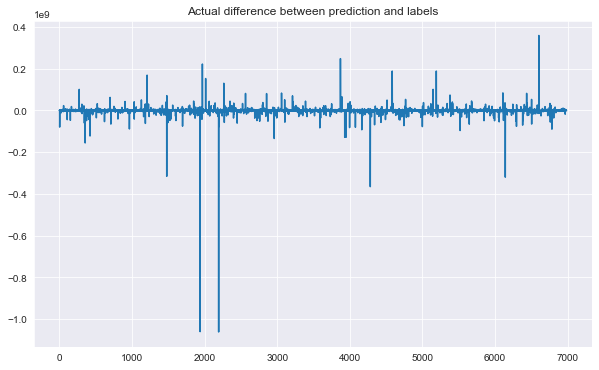

In [297]:
diff = combined_average - test_labels
print("Mean actual error:", diff.mean())
visualizer.error_plot(diff, "Actual difference between prediction and labels")

It seems we are still underestimating the value on average, and even though there are spikes, it seems much more controlled this time around. Lets see how it did in the top, mid and low sections.

In [298]:
top_95 = train_data["price"].quantile(0.95)
low_5  = train_data["price"].quantile(0.05)
mid_45 = train_data["price"].quantile(0.45)
mid_55 = train_data["price"].quantile(0.55)

top = train_data[train_data["price"] > top_95]
low = train_data[train_data["price"] < low_5]
mid_temp = train_data[train_data["price"] > mid_45]
mid = mid_temp[mid_temp["price"] < mid_55]

top_mean = np.round(np.expm1(top["price"]).mean())
mid_mean = np.round(np.expm1(mid["price"]).mean())
low_mean = np.round(np.expm1(low["price"]).mean())
                    
top_labels = top["price"]
mid_labels = mid["price"]
low_labels = low["price"]

top = preprocessor.remove_labels(top.copy(), "price")
mid = preprocessor.remove_labels(mid.copy(), "price")
low = preprocessor.remove_labels(low.copy(), "price")

# Top
test_pred_top_boost = np.round([np.expm1(pred) for pred in xgboost_model.autoMLpredict(top)])
test_pred_top_lgbm = np.round([np.expm1(pred) for pred in lgbm_model.autoMLpredict(top)])
combined_top = (test_pred_top_boost + test_pred_top_lgbm) / 2
test_labels_top = np.round([np.expm1(lab)for lab in top_labels])

# Mid
test_pred_mid_boost = np.round([np.expm1(pred) for pred in xgboost_model.autoMLpredict(mid)])
test_pred_mid_lgbm = np.round([np.expm1(pred) for pred in lgbm_model.autoMLpredict(mid)])
combined_mid = (test_pred_mid_boost + test_pred_mid_lgbm) / 2
test_labels_mid = np.round([np.expm1(lab)for lab in mid_labels])

# Low
test_pred_low_boost = np.round([np.expm1(pred) for pred in xgboost_model.autoMLpredict(low)])
test_pred_low_lgbm = np.round([np.expm1(pred) for pred in lgbm_model.autoMLpredict(low)])
combined_low = (test_pred_low_boost + test_pred_low_lgbm) / 2
test_labels_low = np.round([np.expm1(lab)for lab in low_labels])

print("RMSLE TOP: %s" % general_model.root_mean_squared_log_error(test_labels_top, combined_top))
print("RMSLE MID: %s" % general_model.root_mean_squared_log_error(test_labels_mid, combined_mid))
print("RMSLE LOW: %s" % general_model.root_mean_squared_log_error(test_labels_low, combined_low))

RMSLE TOP: 0.20304773257784395
RMSLE MID: 0.08074706851741548
RMSLE LOW: 0.1363618369634156


This is much better than last time. We are still having troubles with the very high end apartments, but the RMSLE is significantly lower. Lets just plot the predictions vs actual price for these three subsets. In the finished model, we will counteract the difficulty of predicting expensive buldings by altering the labels themselves. We will have the labels bein `price / area_total`. This means that we will have to multiply with *area_total* after the prediction.

Mean error on top 95%: -11082721.0 rubels
Mean absolute error on top 95%: 25990479.0 rubels
The error is 0.1525 times the mean price



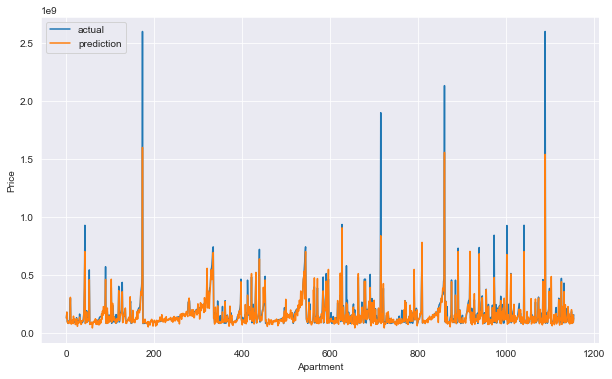

In [299]:
top_df = pd.DataFrame({ "actual": test_labels_top, "prediction": combined_top}, index=range(0, 1155))
top_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
top_diff = combined_top - test_labels_top
print(f"Mean error on top 95%: {np.round(top_diff.mean())} rubels")
print(f"Mean absolute error on top 95%:", np.round(abs(combined_top - test_labels_top).mean()), "rubels")
print(f"The error is {np.round(abs(combined_top - test_labels_top).mean()/top_mean, 4)} times the mean price\n")

Mean error on mid 10%: -1431.0 rubels
Mean absolute error on low 95%: 613536.0 rubels
The error is 0.0574 times the mean price



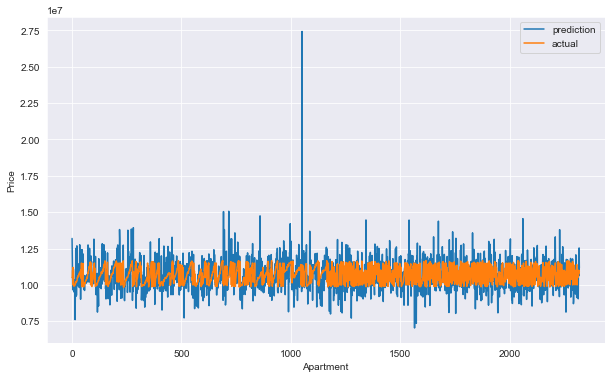

In [300]:
mid_df = pd.DataFrame({ "prediction": combined_mid,"actual": test_labels_mid}, index=range(0, 2319))
mid_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
mid_diff = combined_mid - test_labels_mid
print(f"Mean error on mid 10%: {np.round(mid_diff.mean())} rubels")
print(f"Mean absolute error on low 95%:", np.round(abs(combined_mid - test_labels_mid).mean()), "rubels")
print(f"The error is {np.round(abs(combined_mid - test_labels_mid).mean()/mid_mean, 4)} times the mean price\n")

Mean error on low 95%: 222060.0 rubels
Mean absolute error on low 95%: 366526.0 rubels
The error is 0.0854 times the mean price


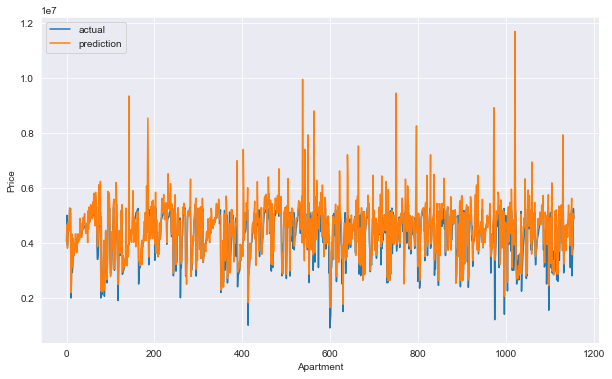

In [301]:
low_df = pd.DataFrame({ "actual": test_labels_low, "prediction": combined_low}, index=range(0, 1155))
low_df.plot(ax=plt.gca(), figsize=(10, 6), ylabel="Price", xlabel="Apartment")
low_diff = combined_low - test_labels_low
print(f"Mean error on low 95%: {np.round(low_diff.mean())} rubels")
print(f"Mean absolute error on low 95%:", np.round(abs(combined_low - test_labels_low).mean()), "rubels")
print(f"The error is {np.round(abs(combined_low - test_labels_low).mean()/low_mean, 4)} times the mean price")

### Adding *area_distance* feature to counteract the importance of *area_total* and *distance_center*

We see that the predictions are much closer to the actual prices now - which of course is very good. As we are struggelig so much with the higher end apartments, mainly because it is hard for the model to predict as the *area_total* feature and *distance_center* features are misinterpreted - lets make a new feature combining these into one - namely *area_distance*. We will use the logified distance and divide it by the original non-logified version of *area_total*. Lets see if it does anything.

In [302]:
area_distance = categorical_feat["distance_center"] / merged_final["area_total"]
categorical_feat["area_distance"] = area_distance

Now, lets try to use the same way by combining the two models *XGBoost* and *LGBM* into one predictions file. First though, we need to find the models. We do this with *AutoML*.

In [303]:
train_data = categorical_feat[:23285].copy()
test_data = categorical_feat[23285:].copy()
test_data.drop("price", 1, inplace=True)

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data.district, test_size=0.3)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print(f"Number of features:", x_train.shape[1])

Number of features: 21


In [304]:
xgboost_model = TestModel(x_train, y_train)
xgboost_model.autoMLfit(x_train, y_train, ["xgboost"], time=120)
xgboost_pred = np.round([np.expm1(pred) for pred in xgboost_model.autoMLpredict(x_test)])

lgbm_model = TestModel(x_train, y_train)
lgbm_model.autoMLfit(x_train, y_train, ["lgbm"], time=120)
lgbm_pred = np.round([np.expm1(pred) for pred in lgbm_model.autoMLpredict(x_test)])

[flaml.automl: 11-19 03:50:24] {1485} INFO - Data split method: uniform
[flaml.automl: 11-19 03:50:24] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-19 03:50:24] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-19 03:50:24] {1577} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl: 11-19 03:50:24] {1826} INFO - iteration 0, current learner xgboost
[flaml.automl: 11-19 03:50:25] {1943} INFO - Estimated sufficient time budget=4595s. Estimated necessary time budget=5s.
[flaml.automl: 11-19 03:50:25] {2023} INFO -  at 0.6s,	estimator xgboost's best error=0.9159,	best estimator xgboost's best error=0.9159
[flaml.automl: 11-19 03:50:25] {1826} INFO - iteration 1, current learner xgboost
[flaml.automl: 11-19 03:50:25] {2023} INFO -  at 0.8s,	estimator xgboost's best error=0.9159,	best estimator xgboost's best error=0.9159
[flaml.automl: 11-19 03:50:25] {1826} INFO - iteration 2, current learner xgboost
[flaml.automl: 11-19 03:50:25] {202

In [305]:
xgboost_model.autoML_print_best_model()
print("\n")
lgbm_model.autoML_print_best_model()

best model xgboost
configs {'n_estimators': 1033, 'max_leaves': 521, 'min_child_weight': 27.504020831998066, 'learning_rate': 0.014360166708458166, 'subsample': 0.5577615681009093, 'colsample_bylevel': 0.9866999664730675, 'colsample_bytree': 0.3569827908214031, 'reg_alpha': 0.4249461080353623, 'reg_lambda': 1.647383797916533}


best model lgbm
configs {'n_estimators': 9107, 'num_leaves': 6, 'min_child_samples': 3, 'learning_rate': 0.024245275406563346, 'log_max_bin': 7, 'colsample_bytree': 0.5895041233290715, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.009767001070180267}


In [306]:
test_labels = np.round([np.expm1(lab)for lab in y_test])
combined_average = (lgbm_pred + xgboost_pred)/2

print("RMSLE for XGBoost model: %s" % xgboost_model.root_mean_squared_log_error(test_labels, xgboost_pred))
print("RMSLE for LGBM model: %s\n" % lgbm_model.root_mean_squared_log_error(test_labels, lgbm_pred))

print("RMSLE for combined models: %s\n" % general_model.root_mean_squared_log_error(test_labels, combined_average))


RMSLE for XGBoost model: 0.13760682638759741
RMSLE for LGBM model: 0.13606721576339686

RMSLE for combined models: 0.13313969356335595



Very promising. It seems like the way to go it to take some average of multiple models as if one of them is far off on an apartment, the other will counteract this. It also seems like the distance features did wonders for the results - which is nice to see. We will use a combination of *XGBoost* and *LGBM* for our finished model - and take into consideration everything we have learned in this notebook. The finished model is located inside its own notebook - namely ***short.ipynb***.

### Model interpretation and feature importance of the models

Before we complete the notebook, lets look at the importance of the features we have selected so far for the models

In [315]:
train_data = categorical_feat[:23285].copy()
t_labels = train_data["price"]
train_data.drop("price", 1, inplace=True)
xgb = xgboost_model.xgboost_model(xgboost_model.model.best_config)
lgbm = lgbm_model.lgbm_model(lgbm_model.model.best_config)

In [334]:
print("Fitting XGBoost model...")
xgb_train = train_data.copy()
xgb_train["building_id"] = xgb_train["building_id"].astype("float64")
xgb_train["condition"] = xgb_train["condition"].astype("float64")
xgb.fit(xgb_train, t_labels)
print("Fitting LGBM model...")
lgbm.fit(train_data, t_labels)
print("Fitting complete")

Fitting XGBoost model...
Fitting LGBM model...
Fitting complete


,features,importance
0,area_total,0.349200
1,condition,0.025922
2,building_id,0.002492
3,latitude,0.009488
4,longitude,0.010882
5,district,0.067818
6,closest_subway_distance,0.004372
7,closest_hospital,0.006979
8,closest_park,0.012989
9,distance_luxury_village,0.018017


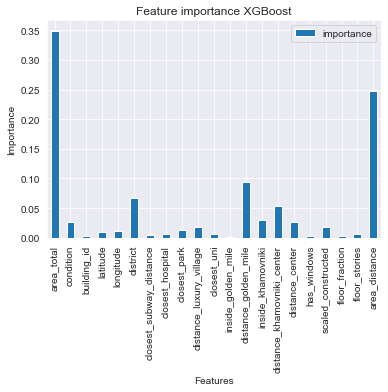

In [335]:
xgb_fi = xgb.feature_importances_
xgb_df = pd.DataFrame({"features": train_data.columns, "importance": xgb_fi})
xgb_df.plot(kind="bar", x="features", xlabel="Features", ylabel="Importance", title="Feature importance XGBoost")
xgb_df

We see that the total area is the biggest one - which makes sense. There are a lot of features not really that important it seems. Something to keep in mind when creating the actual model. The newest feature - *area_distance* - is a key feature. We already discovered that this helped our model, and this confirms it. Lets now look at the *LGBM* model an see if we see anything similar, or if they disagree on something.

,features,importance
0,area_total,5261
1,condition,860
2,building_id,3699
3,latitude,2430
4,longitude,1984
5,district,570
6,closest_subway_distance,2125
7,closest_hospital,2293
8,closest_park,2182
9,distance_luxury_village,2212


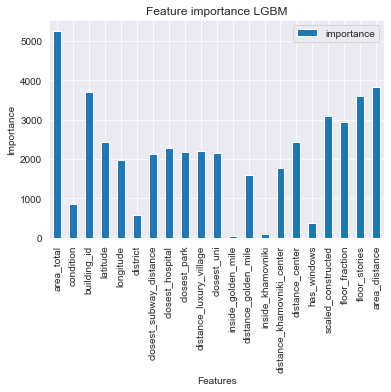

In [336]:
lgbm_fi = lgbm.feature_importances_
lgbm_fi_df = pd.DataFrame({"features": train_data.columns, "importance": lgbm_fi})
lgbm_fi_df.plot(kind="bar", x="features", xlabel="Features", ylabel="Importance", title="Feature importance LGBM")
lgbm_fi_df

Whoa! <br>
They do not agree at all. It seems like *LGBM* puts more weight into each individual distance feature, and not as much in area total as one might believe. It also almost completely ignores the *inside_golden_mile* feature. It is very interesting that two models weighing the features in such different manners are both able to perform around quite similar.

## Summary

In this notebook we have tried to get insight in the dataset provided to solve the problem of predicting housing prices in Moscow. We started the show by cleaning the data, removing features with a overwhelming amount of *NaN* values, and imputing the rest so that no *NaN* values are present in the dataset. The way we impute the *NaNs* differ from entry to entry based on different parameters like *district*, or if the data is categorical, boolean, number, continous.

When all the fields in the dataset was filled with actual values, we started the exploration phase where we looked for correlation between the features. In this section, we learned a lot. We discovered correlations where we expected them (like between *area_total* and *price*), but also some places where it might not be so obvious (like apartments in higher floors often being more expensive). This exploration phase had us plotting the features against each other too see if we could find something useful, and also taking mental notes of features that might be eligable for removal as they did not do as much as we might have thought.

After the exploration phase, we started the actual engineering. This is where we combined, altered, removed and added existing and new features trying to create the best possible environment for our models. This was a tiresome process where we needed the insight in the data we got from the exploration phase. We created some great new features (like *distance_center*), and some features that did not live up to our expectations (like *has_elevator*). We started thinking about how we could create new features based on distance - which we did in later sections. This turned out to be a good move.

In the next section, we started trying our new engineered dataset on different types of models. We tried a classic *MLP* at first, but it became clear quite quickly that this was not up to par with what we wanted. We then tried *RandomForest*, which was OK, but we suspect that it overfitted too much, as the validation score did not perform as well as it had us believe. Later in this section, we discovered that the two best models (out of the four we tried) was: *XGBoost* and *LGBM*. We did some light error analysis for the intitial configurations for all four of these models, until we started using Microsofts auto ML library *flaml* to find the best ones. 

Before utilizing *AutoML* to the fullest however, we tried the classic *GridSearchCV* for trying out different configurations of models in an efficient manner. This did not yield results as good as we wanted however, and it took a lot of time running the scripts. Because of this, we discarded the idea, and used *AutoML* istead. This was a good call, as it did not take long until it found models worth analysing.

The error analysis part had us plotting the prediction vs. the actual prices to see where our model went wrong, and if we could do something about it. We created three different subsets of the training set to see where our model erred the most. These three subsets consisted of the top 5%, low 5% and 45-55% of expensive houses - named *top*, *low* and *mid* repectively. This showed us that our model performed the best in the middle sector, OK in the low sector, but quite poor in the top sector. One reason for this is that the houses are so expensive, that when the model first guesses wrong, it will be off by millions. This section gave us valuable insight in how the model performed, and has us starting to think about new features to counteract this flaw.

One thing that our model did wrong was relying too much on the total area of the apartment (or house). Of course, large apartments are often more expensive, but not when they are far away from the action (city center). Because of this, we started adding multiple distance features to schools, metro stations, rich neighborhoods and more. This was a success, and helped our model a lot. We also added a new featuer *area_distance* which combined *area_total* and *distance_center* into a new feature to try to force the model to give more emphasis to the distance. This seemed to work quite well, as the score did improve.

The last thing we did, before interpreting the models, was to combine the results of two models - *XGBoost* and *LGBM* - into one prediction list by taking the average of the two. This actually helped our model perform better, and is something we will look at when designing our finished model. The plotting of feature importance showed us that not all the distance features needs to be present. This is something we will take into consideration when we decide which features should be included in the finished model.

This concludes the long notebook. We hope that we have made a readable notebook with descriptions making the somewhat dry code more interesting to read. We tried to counteract this by putting the actual core code into their own seperate classes, and importing them into the notebook. As stated earlier, inside ***short.ipynb***, you will find the finished model with comments and more information about how we accieved the end score.

***Thank you for reading***<br>
Sincerely, <br>
Hauk, Charbel and Noran